# Extract the Statistics for the different scoring functions for each TF

In [1]:
tf_list = ["lola", "pan", "usp", "Dfd", "h", "Su(H)", "Trl"]

score_key = ['energy', 'gomer','sumlog', 'sumoc','maxoc', 'ama', 'maxlog']
stats = ['spearman', "auc", "mncp", "pearson"]
for stat in stats:
    if stat == "auc":
        idx = 1
    elif stat == "mncp":
        idx = 2
    elif stat == "pearson":
        idx = 3
    elif stat == 'spearman':
        idx = 4
    else:
        continue
    for tf in tf_list:
        tf2 = tf.replace("(","").replace(")","")
        results_path = "Results/"+ tf2 
        raw_data = []
        raw_data.append(["Motif"])
        flag = 0
        for key in score_key:
            i = 1
            raw_data[0].append(key)
            with open('%s/%s.%s' % (results_path,tf2,key), "r") as score_out:
                for line in score_out:
                    if line.split()[1]=="AUC":
                        continue
                    else:
                        if flag ==0:
                            raw_data.append([line.split()[0]])
                            raw_data[i].append(line.split()[idx])
                            i+=1
                        else:
                            raw_data[i].append(line.split()[idx])
                            i+=1
                flag = 1

            with open("%s/%s_%s.rawscores" %(results_path,tf2, stat), 'w') as raw_out:
                for row in raw_data:
                    raw_out.writelines('\t'.join(map(str, row)) + '\n')



## Extract Motif Information content

In [2]:
from __future__ import print_function
import sys
from math import log
import os

def mot_summary(motif_file, raw_scores, out_file):
    '''
    Summary of motif and score
    '''
    found = 0
    row = 0
    n_rows = 0
    entropy = 0
    total_entropy = 0
    motifs = 0
    name = ""
    raw_dict = {}
    with open(out_file, "w") as write_out:

        with open(raw_scores) as raw_in:
            for line in raw_in:
                raw_dict[line.split()[0]] = line.split()[1:]
        out = "Motif_name\tMotif_IC\tAverage_IC\tMotif_length\t%s\t%s\t%s\t%s\n" % \
              (raw_dict["Motif"][0], raw_dict["Motif"][1], raw_dict["Motif"][2], raw_dict["Motif"][3])

        write_out.write(out)
        with open(motif_file, "r") as motif_file:
            for line in motif_file:
                words = line.split()
                if found == 0:
                    if line.startswith("MOTIF"):
                        # allow for motifs without an alternative name
                        if len(words) < 3:
                            words.append("")
                        name = (words[1])
                        found = 1
                        motifs += motifs
                        entropy = 0
                        continue
                if found == 1:
                    if line.startswith("letter-probability"):
                        n_rows = int((line.split("w="))[1].split()[0])
                        found = 2
                    continue
                if found == 2:
                    if line == "\n":
                        continue
                    else:
                        check = 0
                    for val in words:
                        if float(val) > 0:
                            check += float(val) * log(float(val))/log(2.0)
                            entropy += float(val) * log(float(val))/log(2.0)
                    row += 1
                    if row >= n_rows:
                        v = 2*n_rows+entropy
                        out = '%s\t%f\t%f\t%i\t%f\t%f\t%f\t%f\n'\
                              % (name, v, (v/n_rows), n_rows, float(raw_dict[name][0]), float(raw_dict[name][1]),
                                 float(raw_dict[name][2]), float(raw_dict[name][3]))
                        write_out.write(out)
                        #n+= 1
                        #print(n)
                        found = 0
                        row = 0
                        total_entropy += (v/n_rows)

In [3]:
statistics = ['auc','mncp']
tf_list = ["lola", "pan", "usp", "Dfd", "h", "SuH", "Trl"]

for stat in statistics:
    for tf in tf_list:
        meme_file = 'Results/%s/%s.meme' %(tf, tf)
        results_path = 'Results/%s' % (tf)
        test = mot_summary(meme_file,"%s/%s_%s.rawscores" % (results_path, tf, stat), "%s/%s_%s_score_ic.txt" % (results_path, tf, stat))

# Specific ChIP-seq peak file correlation 

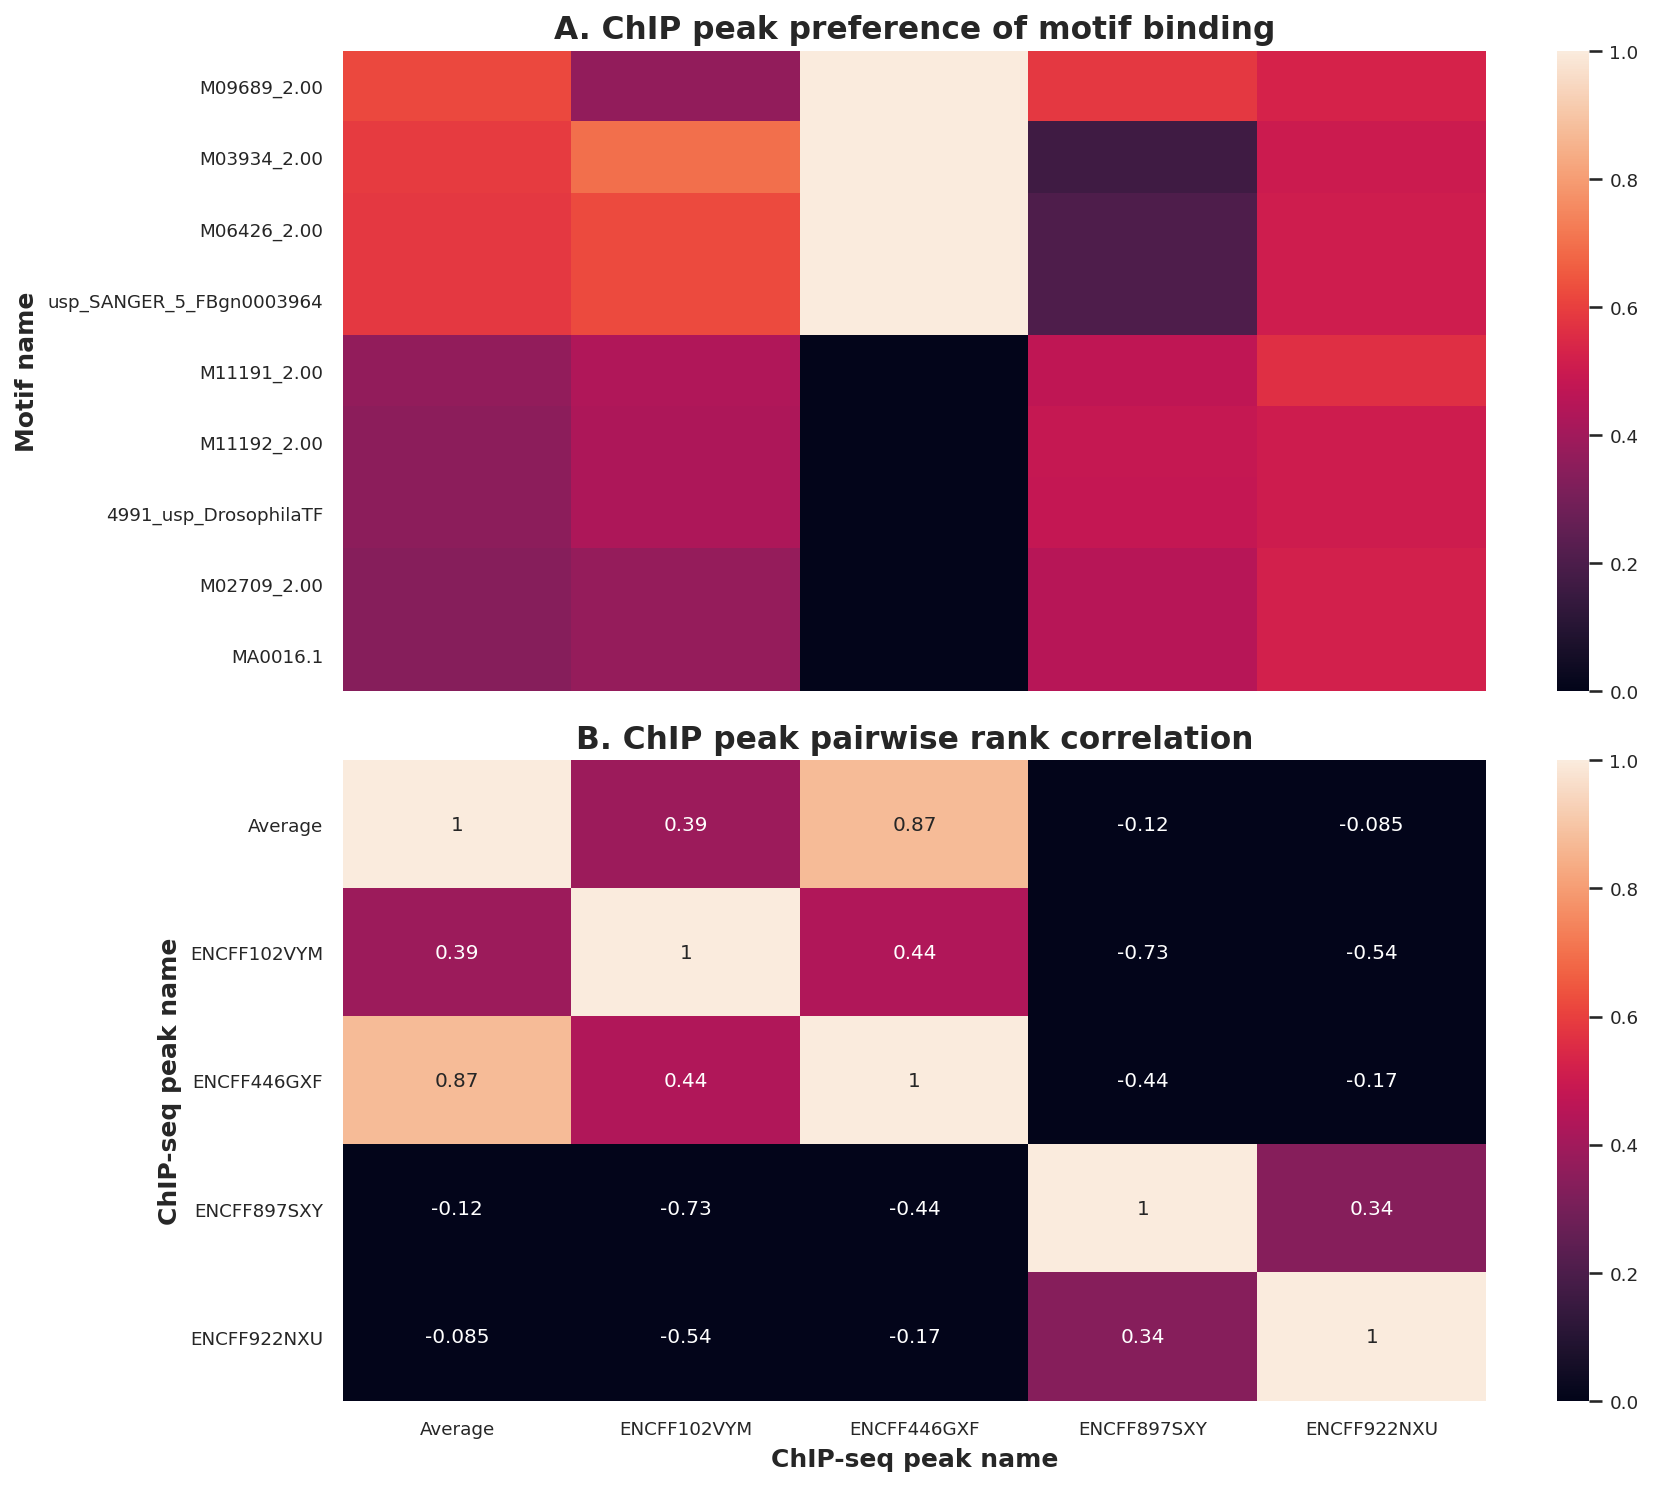

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def plot_raw_assess(raw_data, figure_output, stat):
    """
    This function allows the raw data to be plotted  in the form of a heatmap.
    
    This way, information about how each motif scores in different cell lines is
    obtained
    """
    #Increase the font
#     fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 13), sharex=True, sharey=False)
    sns.set(font_scale=0.8)
    fig = plt.figure(figsize=(12, 10),dpi=150)
    ax1 = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,1,2)
    #sns.set_style("white")
    raw_max = pd.read_table(raw_data)
    raw_max = raw_max.drop_duplicates()
    
    raw_edit = raw_max.pivot('Motif', 'ChIP_file', stat)
    raw_edit.sort_values(by="Average", axis=0, ascending=False, inplace=True)
    #fig, ax = plt.subplots()
    ax1.set_title('A. ChIP peak preference of motif binding',fontdict={'fontsize': 15, 'fontweight':'semibold','ma':'center'})
    ax2.set_title('B. ChIP peak pairwise rank correlation', fontdict={'fontsize': 15, 'fontweight':'semibold','ma':'center'})
    # the size of A4 paper
    sns.heatmap(raw_edit, vmin=0, vmax=1, annot=False,xticklabels=False, ax = ax1)
    sns.heatmap(raw_edit.corr(method='spearman'),vmin=0, vmax=1, ax = ax2, annot=True)
    ax1.set_xlabel("")
    ax1.set_ylabel("Motif name",fontdict={'fontsize': 12, 'fontweight': 'semibold'})
    ax2.set_xlabel("ChIP-seq peak name",fontdict={'fontsize': 12, 'fontweight': 'semibold'})
    ax2.set_ylabel("ChIP-seq peak name",fontdict={'fontsize': 12, 'fontweight': 'semibold'})
    fig.tight_layout()
    f = plt.gcf()
    f.savefig(figure_output, bbox_inches='tight')
    return raw_edit

tf = "usp"
raw_edit = plot_raw_assess("Results/%s/%s_raw.gomer" %(tf,tf), 
                           'Results/%s/%s_specific_gomer.png'%(tf,tf), 'AUC')

lola
pan
usp
Dfd
h
SuH
Trl


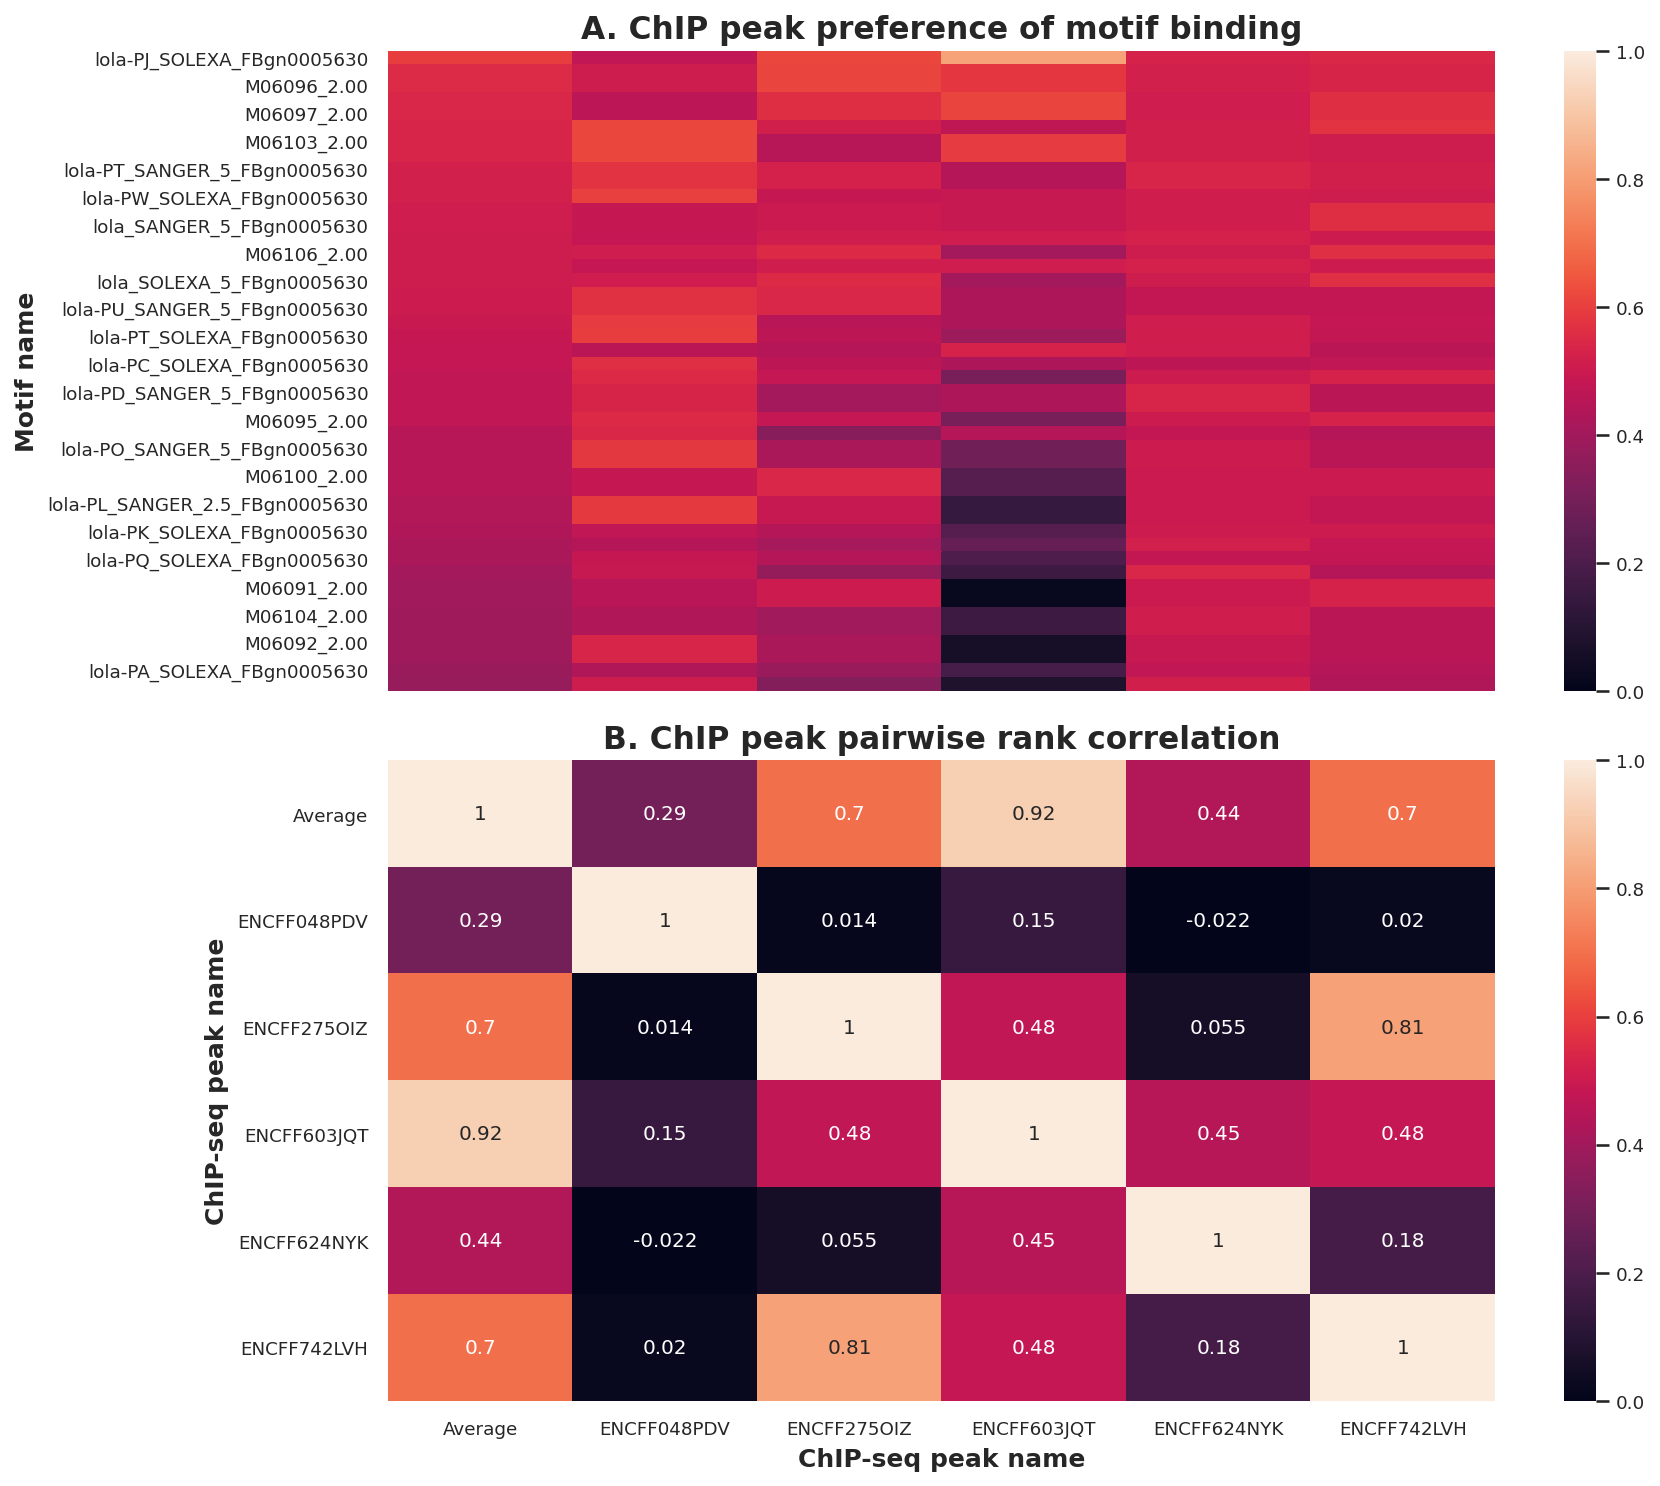

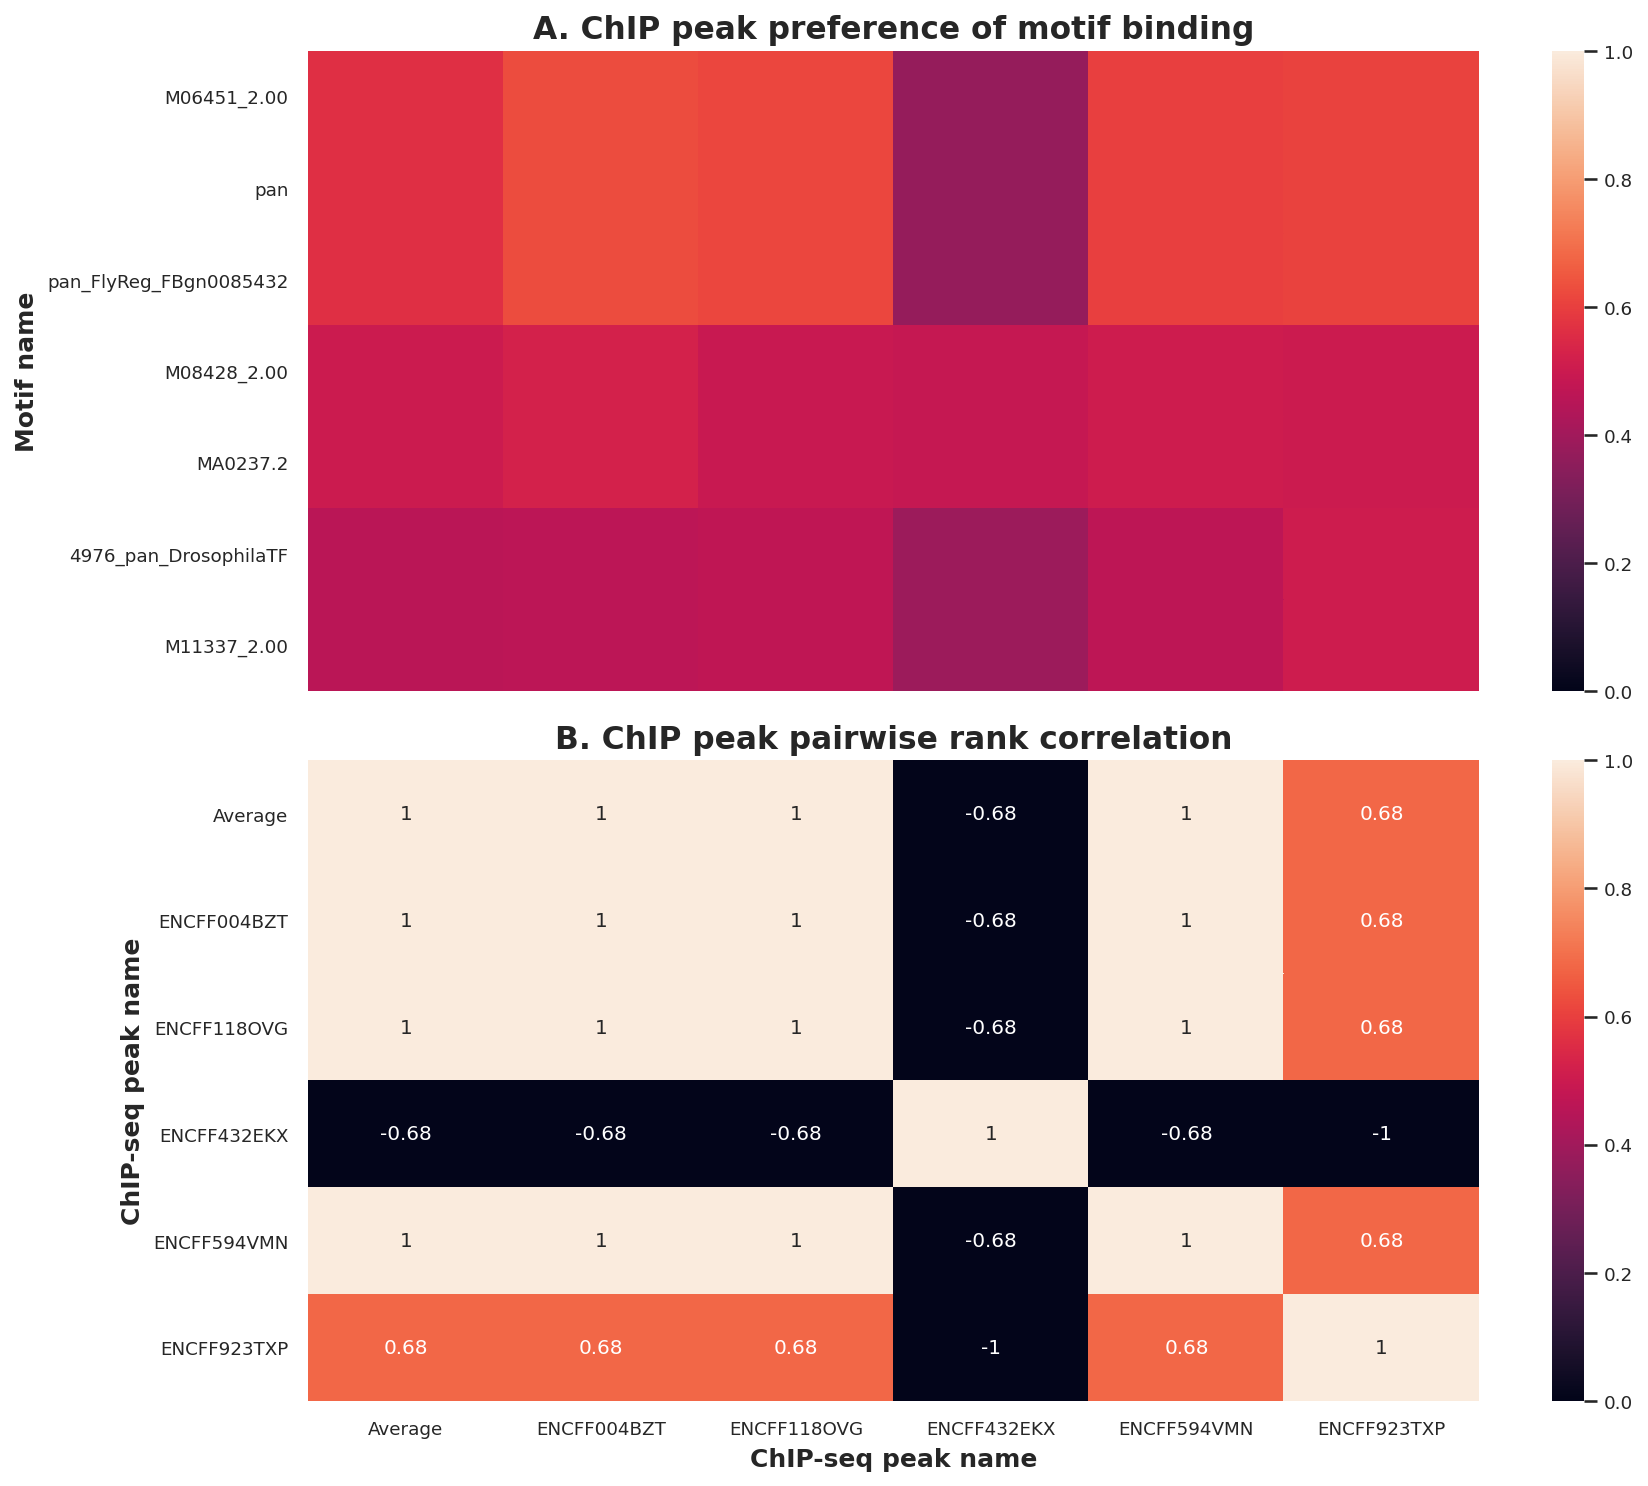

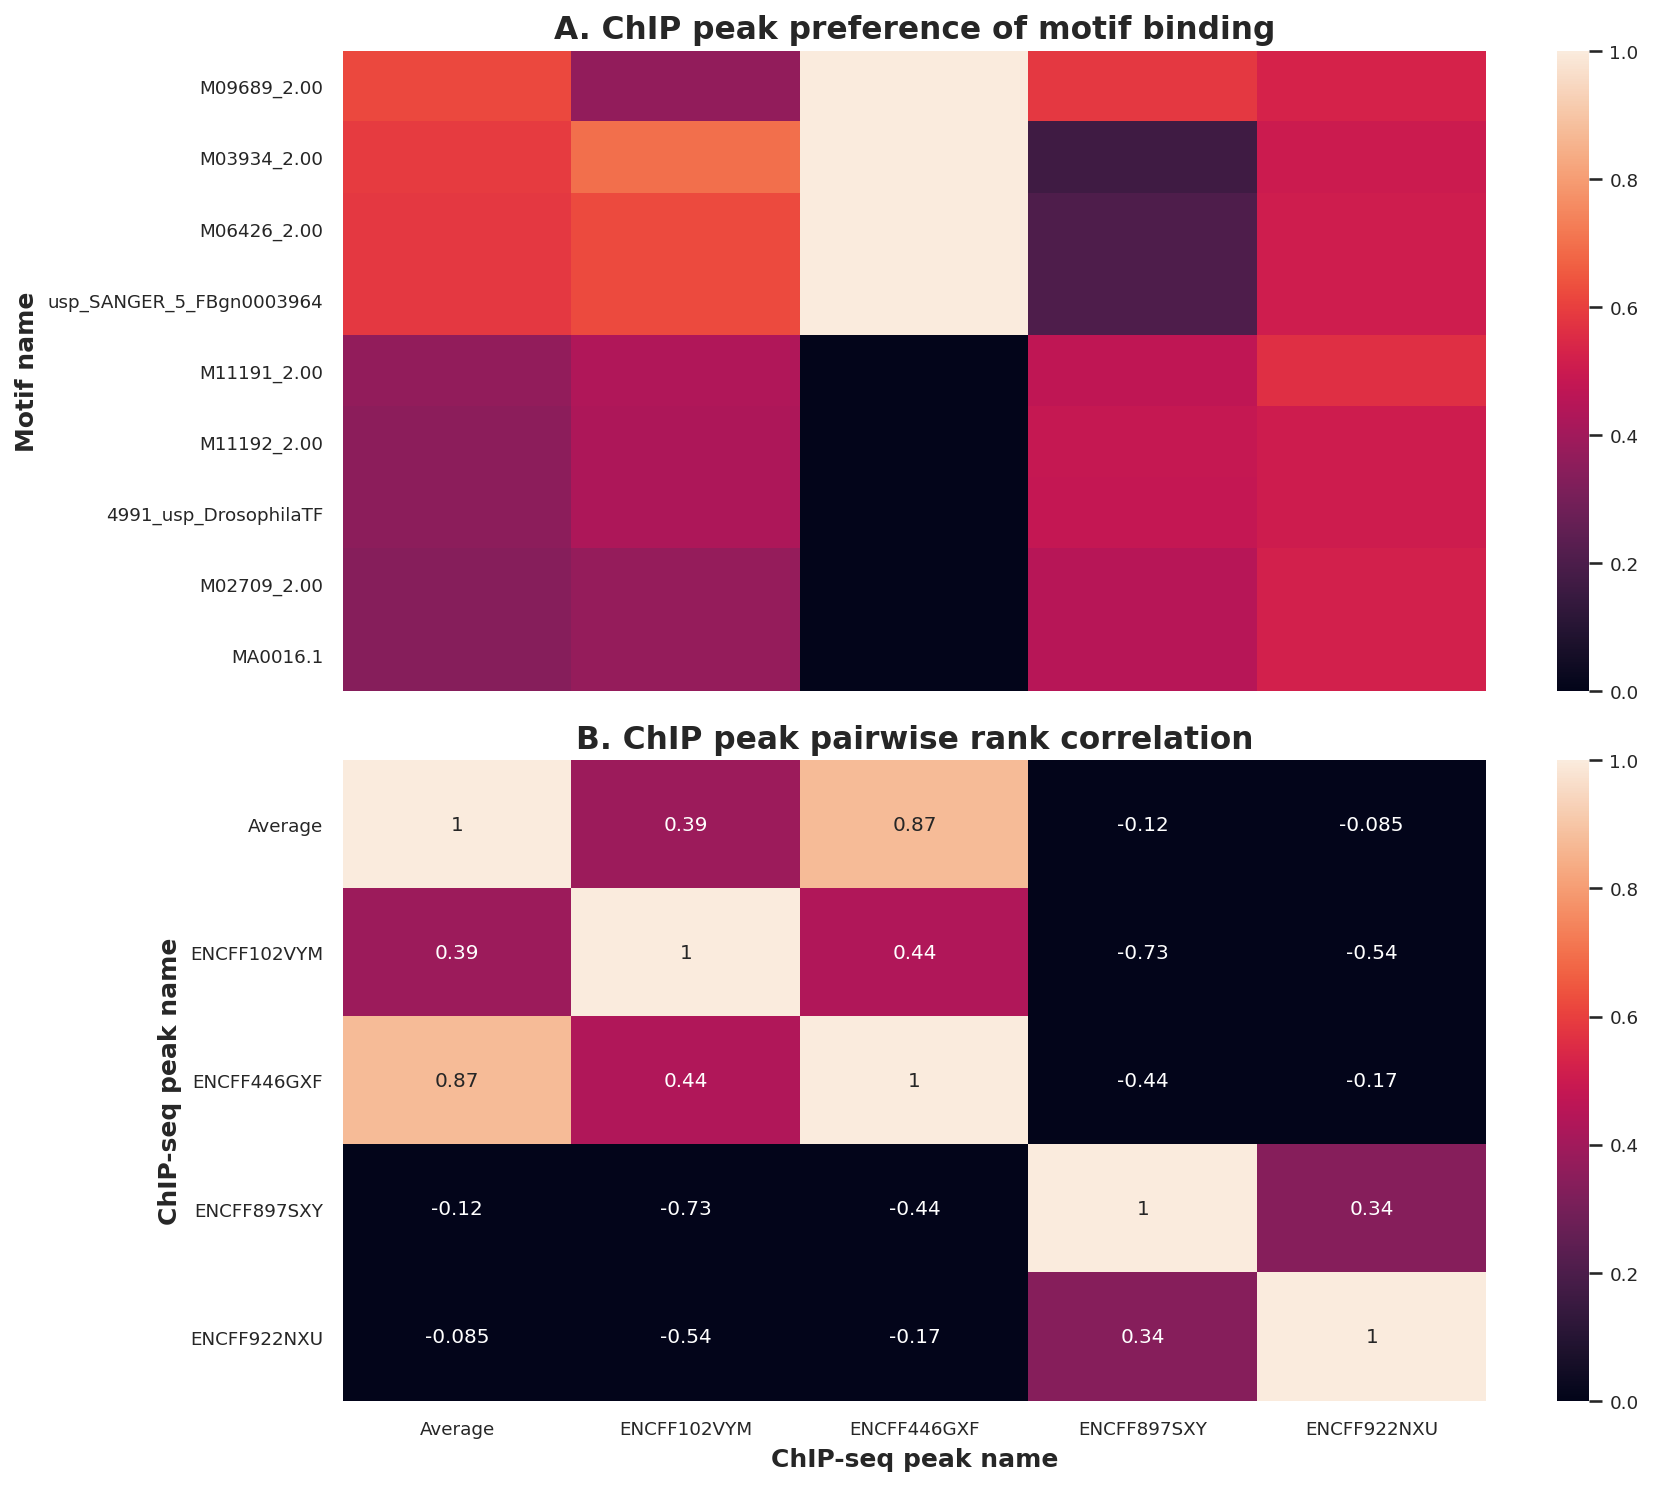

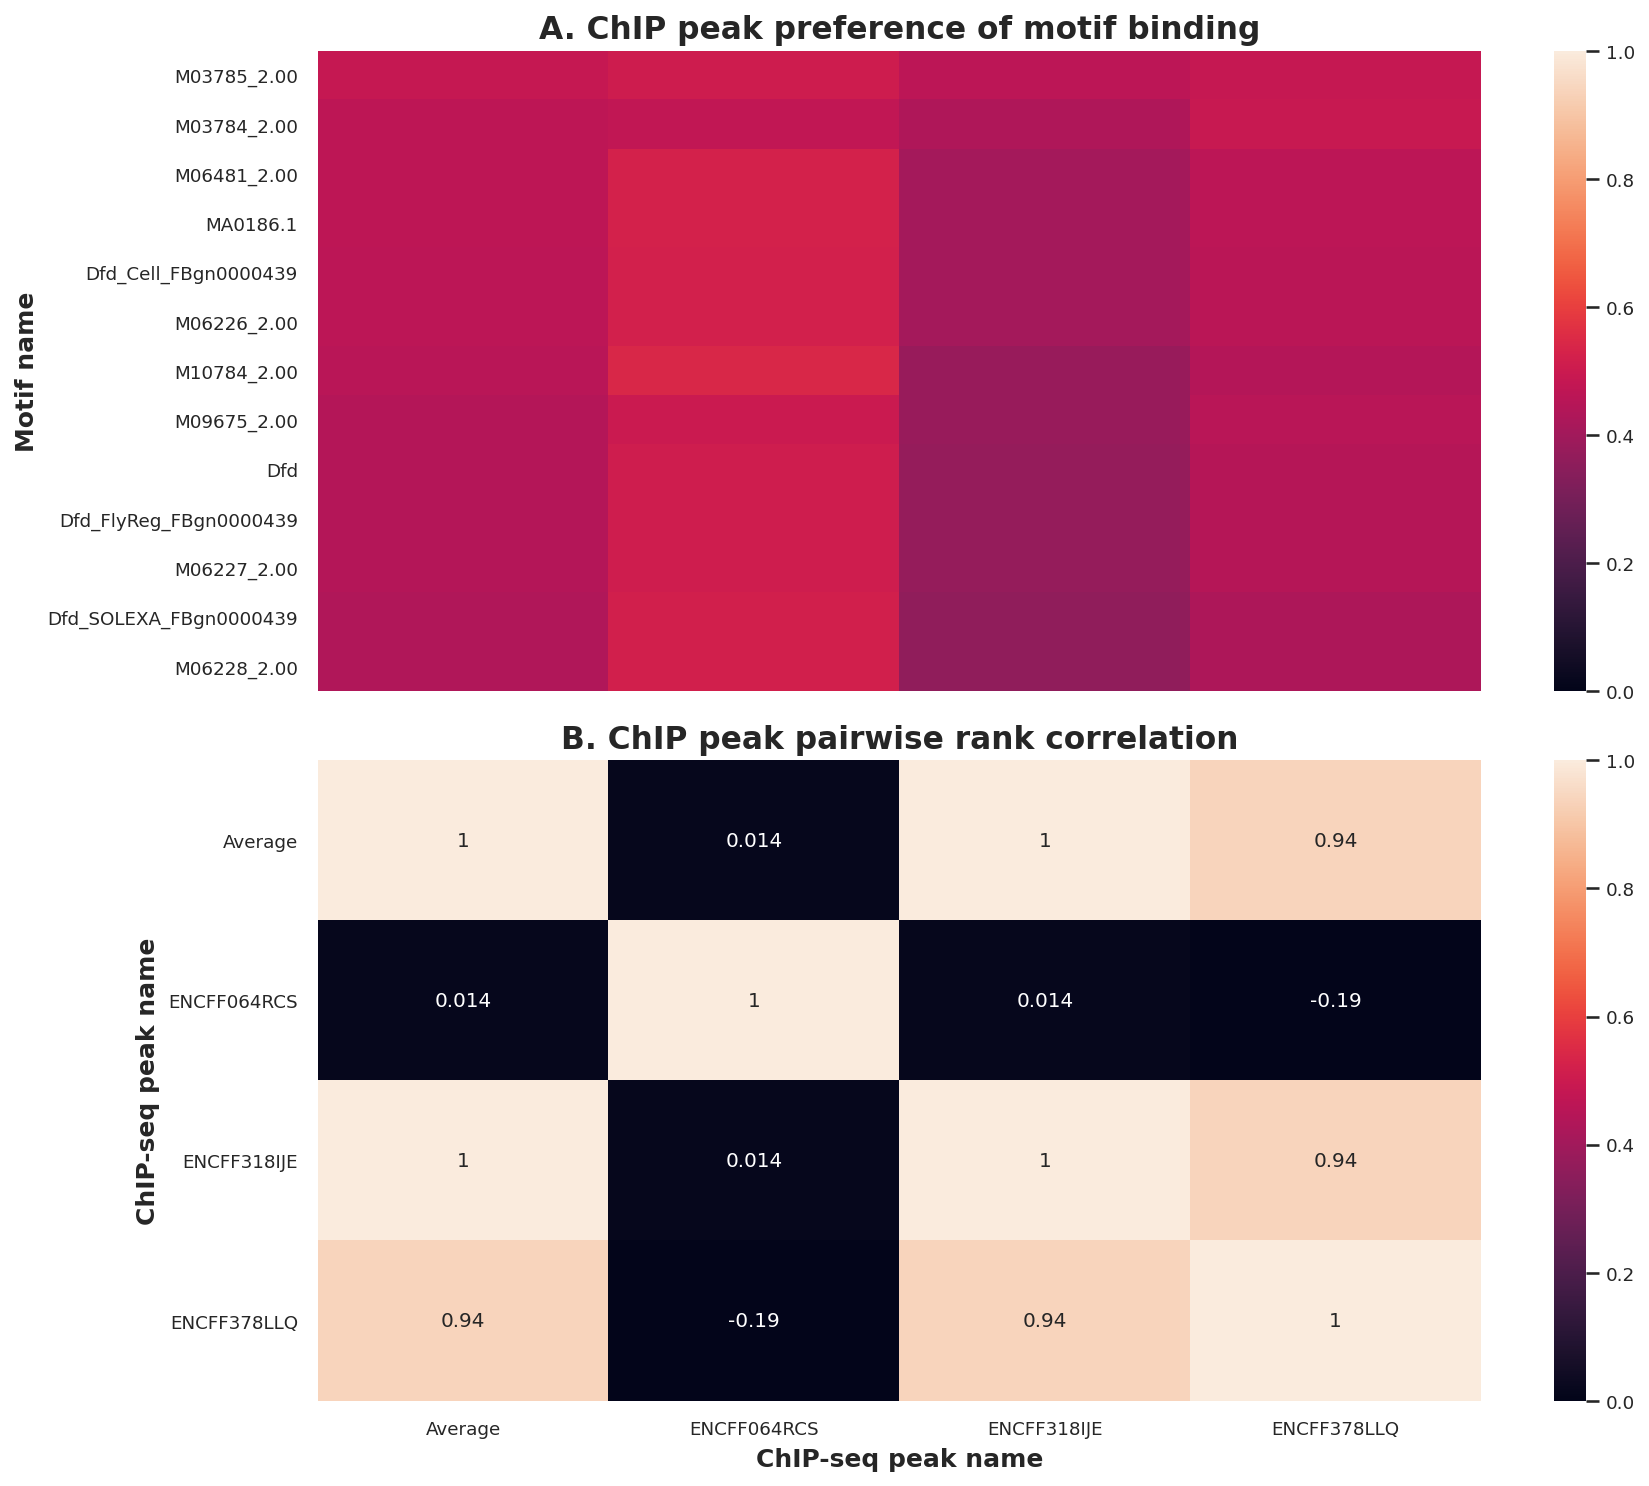

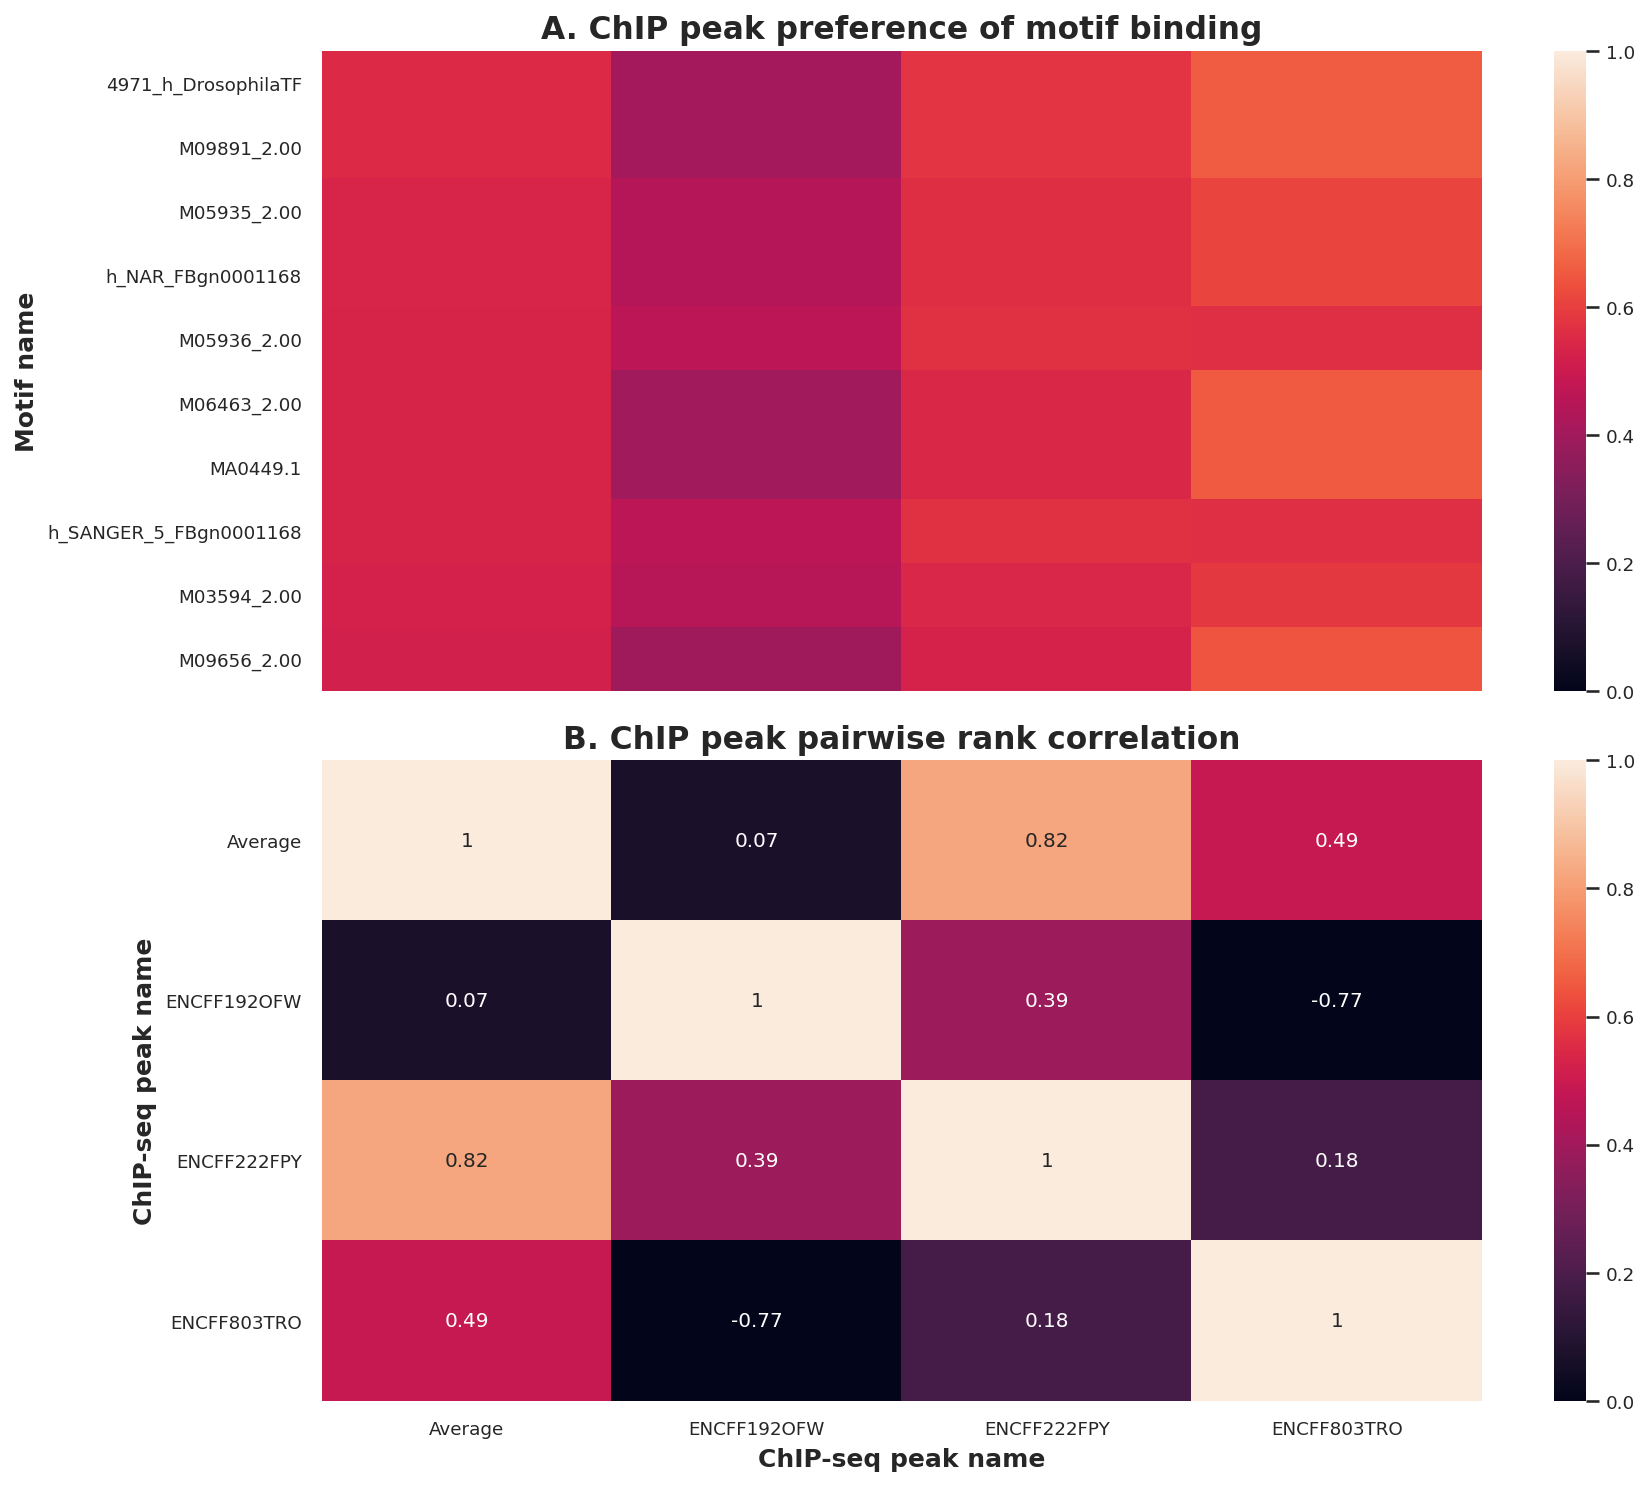

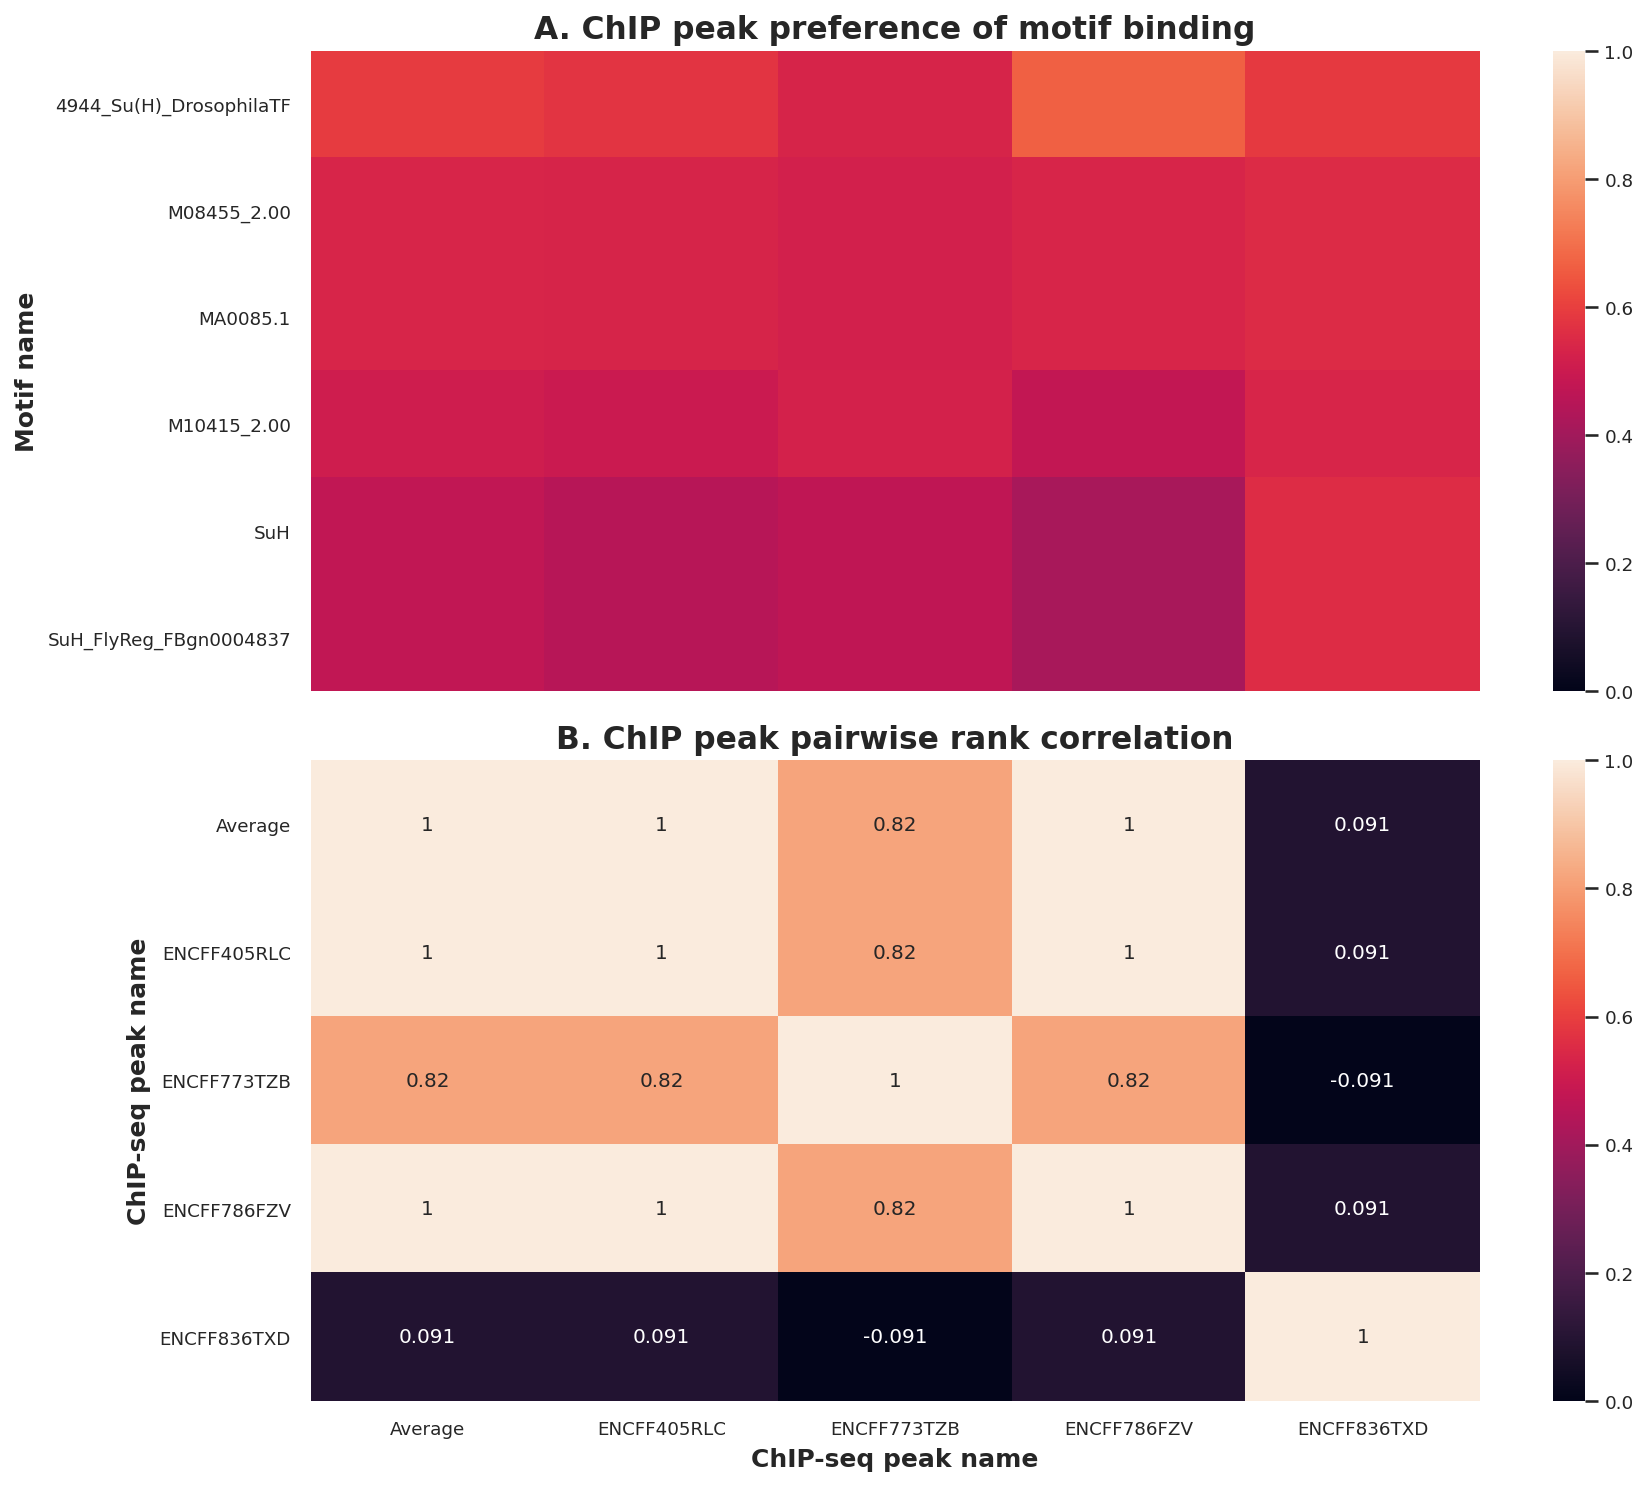

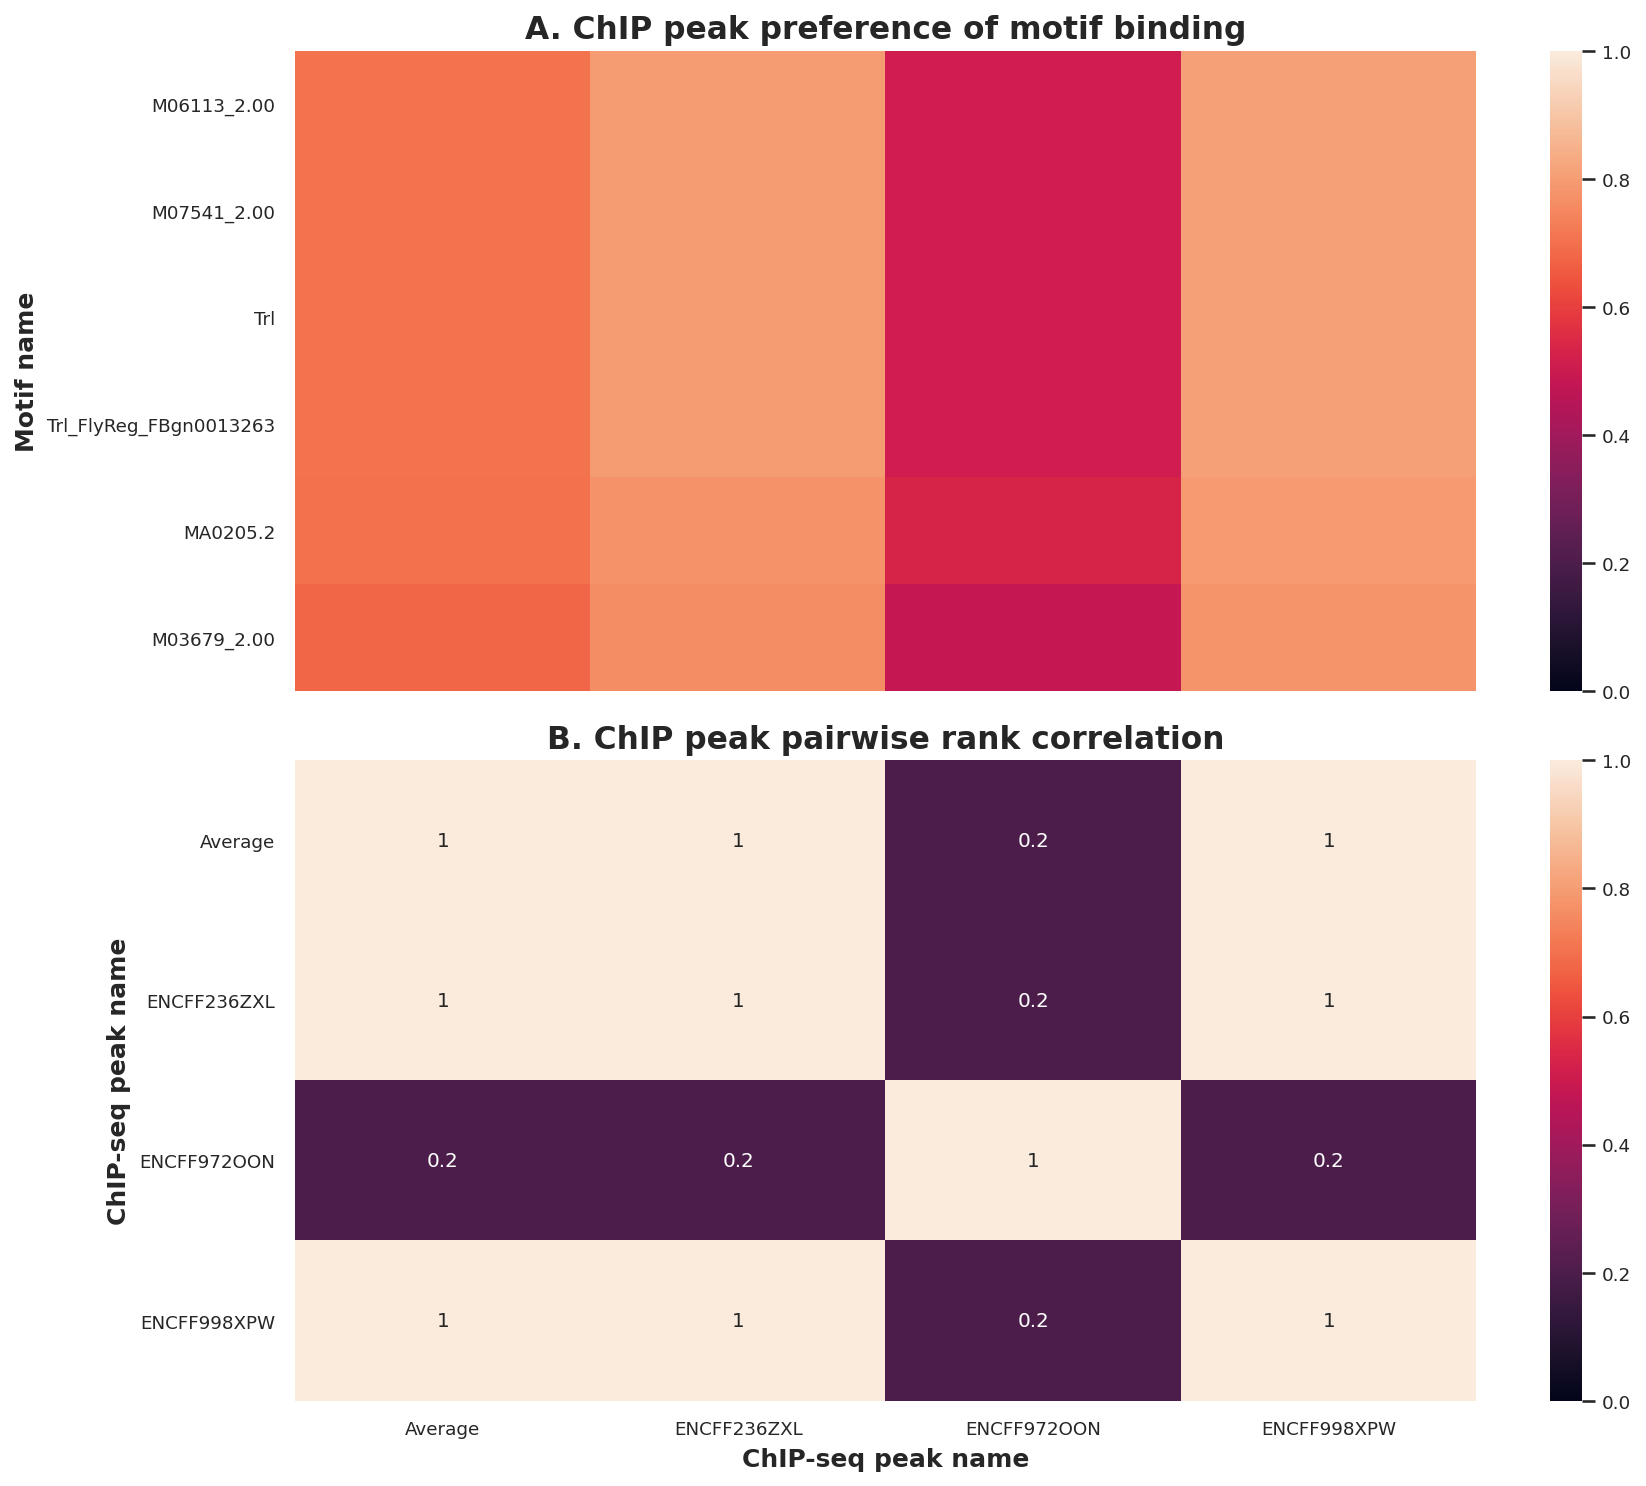

In [5]:
tf_list = ["lola", "pan", "usp", "Dfd", "h", "SuH", "Trl"]

for tf in tf_list:
    print(tf)
    plot_raw_assess("Results/%s/%s_raw.gomer" %(tf,tf), 
                           'Results/%s/%s_specific_gomer.png'%(tf,tf), 'AUC')

# Effect of statistics on motif ranking

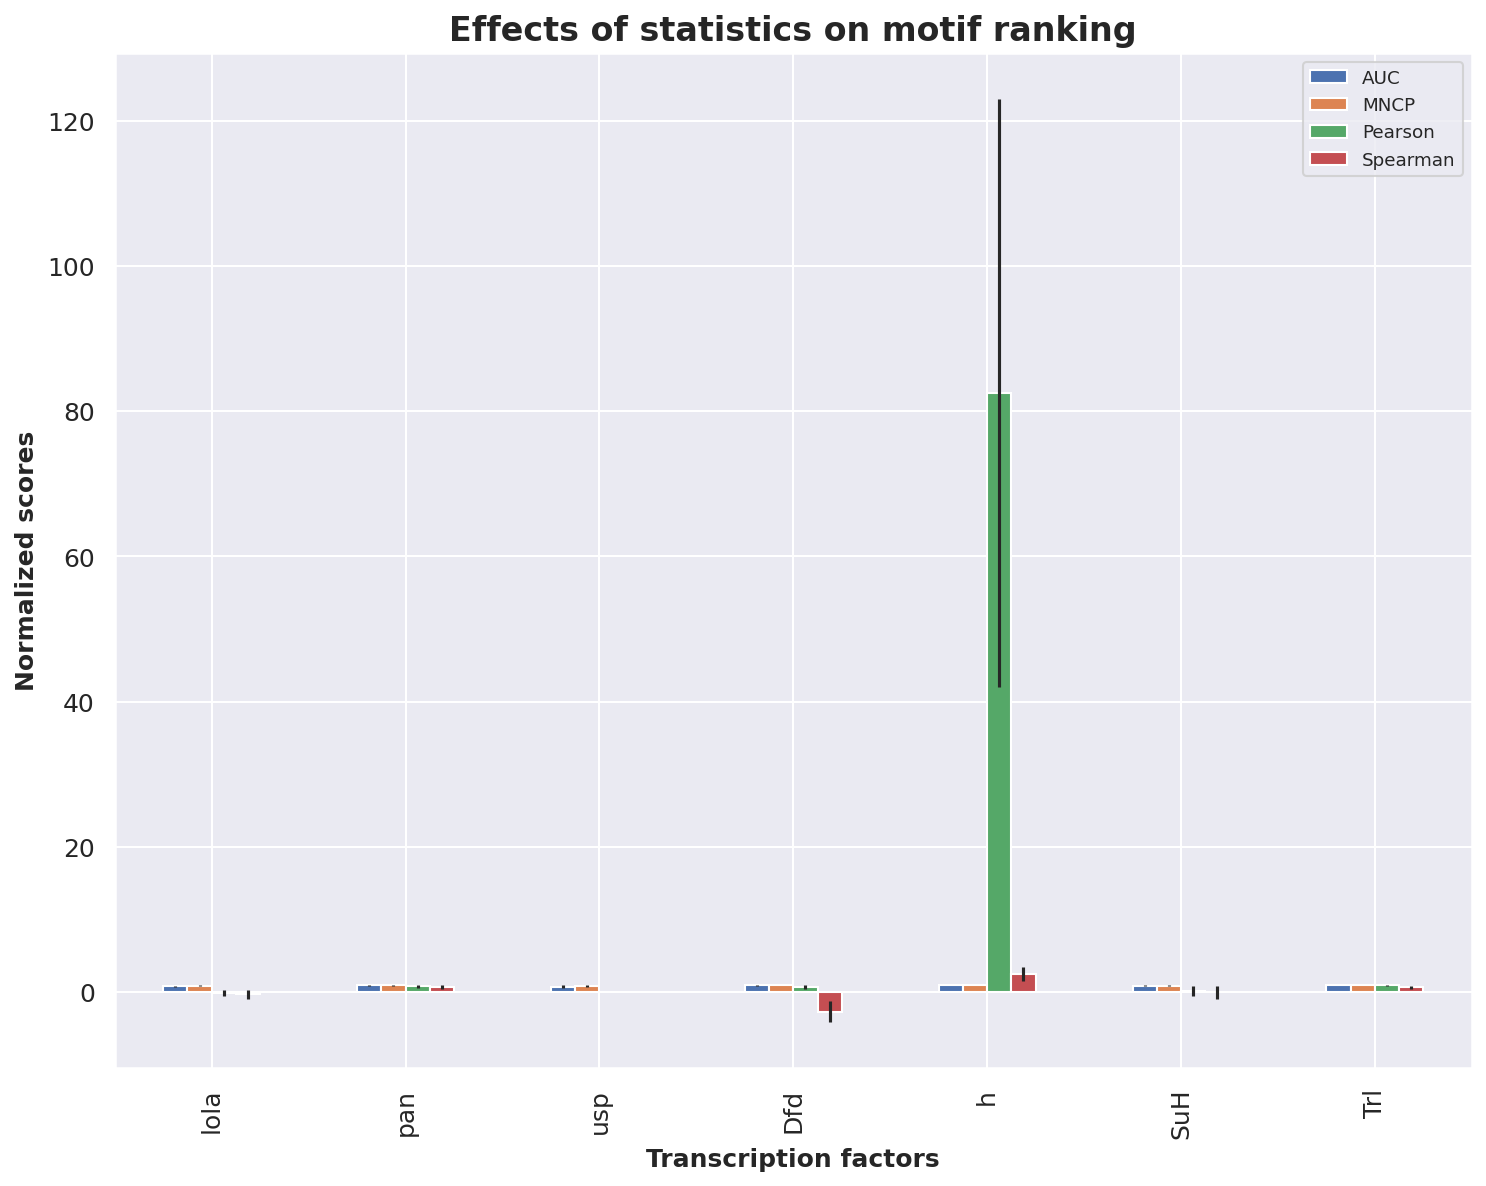

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ranksums
score = 'gomer'
tf_list = ["lola", "pan", "usp", "Dfd", "h", "SuH", "Trl"]

tf = tf_list[0]
chip = pd.read_table('Results/%s/%s.%s' % (tf, tf, score), index_col='Motif')
chip = chip/chip.max()
chip_std = chip.std().to_frame(name=tf).T
chip_mean = np.mean(chip).to_frame(name=tf)
chip_mean_test = chip_mean.T
rank_sum = ranksums(chip['AUC'],chip['Spearman'])[1] # compute wilcoxon rank-sum test

for tf in tf_list[1:]:
    chip = pd.read_table('Results/%s/%s.%s' % (tf, tf, score), index_col='Motif')
    chip = chip/chip.max()
    #print tf
    rank_sum += ranksums(chip['AUC'],chip['Spearman'])[1]
    chip_s = chip.std().to_frame(name=tf)
    chip_std = chip_std.append(chip_s.T)
    chip_mean = np.mean(chip).to_frame(name=tf)
    
    chip_mean_test = chip_mean_test.append(chip_mean.T)

fig = plt.figure(dpi=150)
ax = fig.add_subplot()

chip_mean_test.plot(kind='bar',yerr=chip_std, ax= ax,fontsize=12, figsize=(10,8))
#ax.grid(False)
ax.set_title("Effects of statistics on motif ranking",fontdict={'fontsize': 16, 'fontweight': 'bold'} )
ax.set_xlabel("Transcription factors",fontdict={'fontsize': 12, 'fontweight': 'semibold'})
ax.set_ylabel("Normalized scores", fontdict={'fontsize': 12, 'fontweight': 'semibold'})
#ax.set_axis_bgcolor('W')
fig.tight_layout()
#fig = ax.get_figure()

#fig.savefig('../Figures/Figure5_score_and_statistic_new.pdf')




We tested the effect of the statistics on the gomer motif scoring function and there was a spike in pearson correlation in the h transcription factor. This forced us to run the effect of the statistics on all the different function to find which scoring function works optimumly with the Drosophila data. Sumlog and maxlog scoring function perform well across all transcription factors.

/home/festo/miniconda3/envs/gimme/lib/python3.7/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


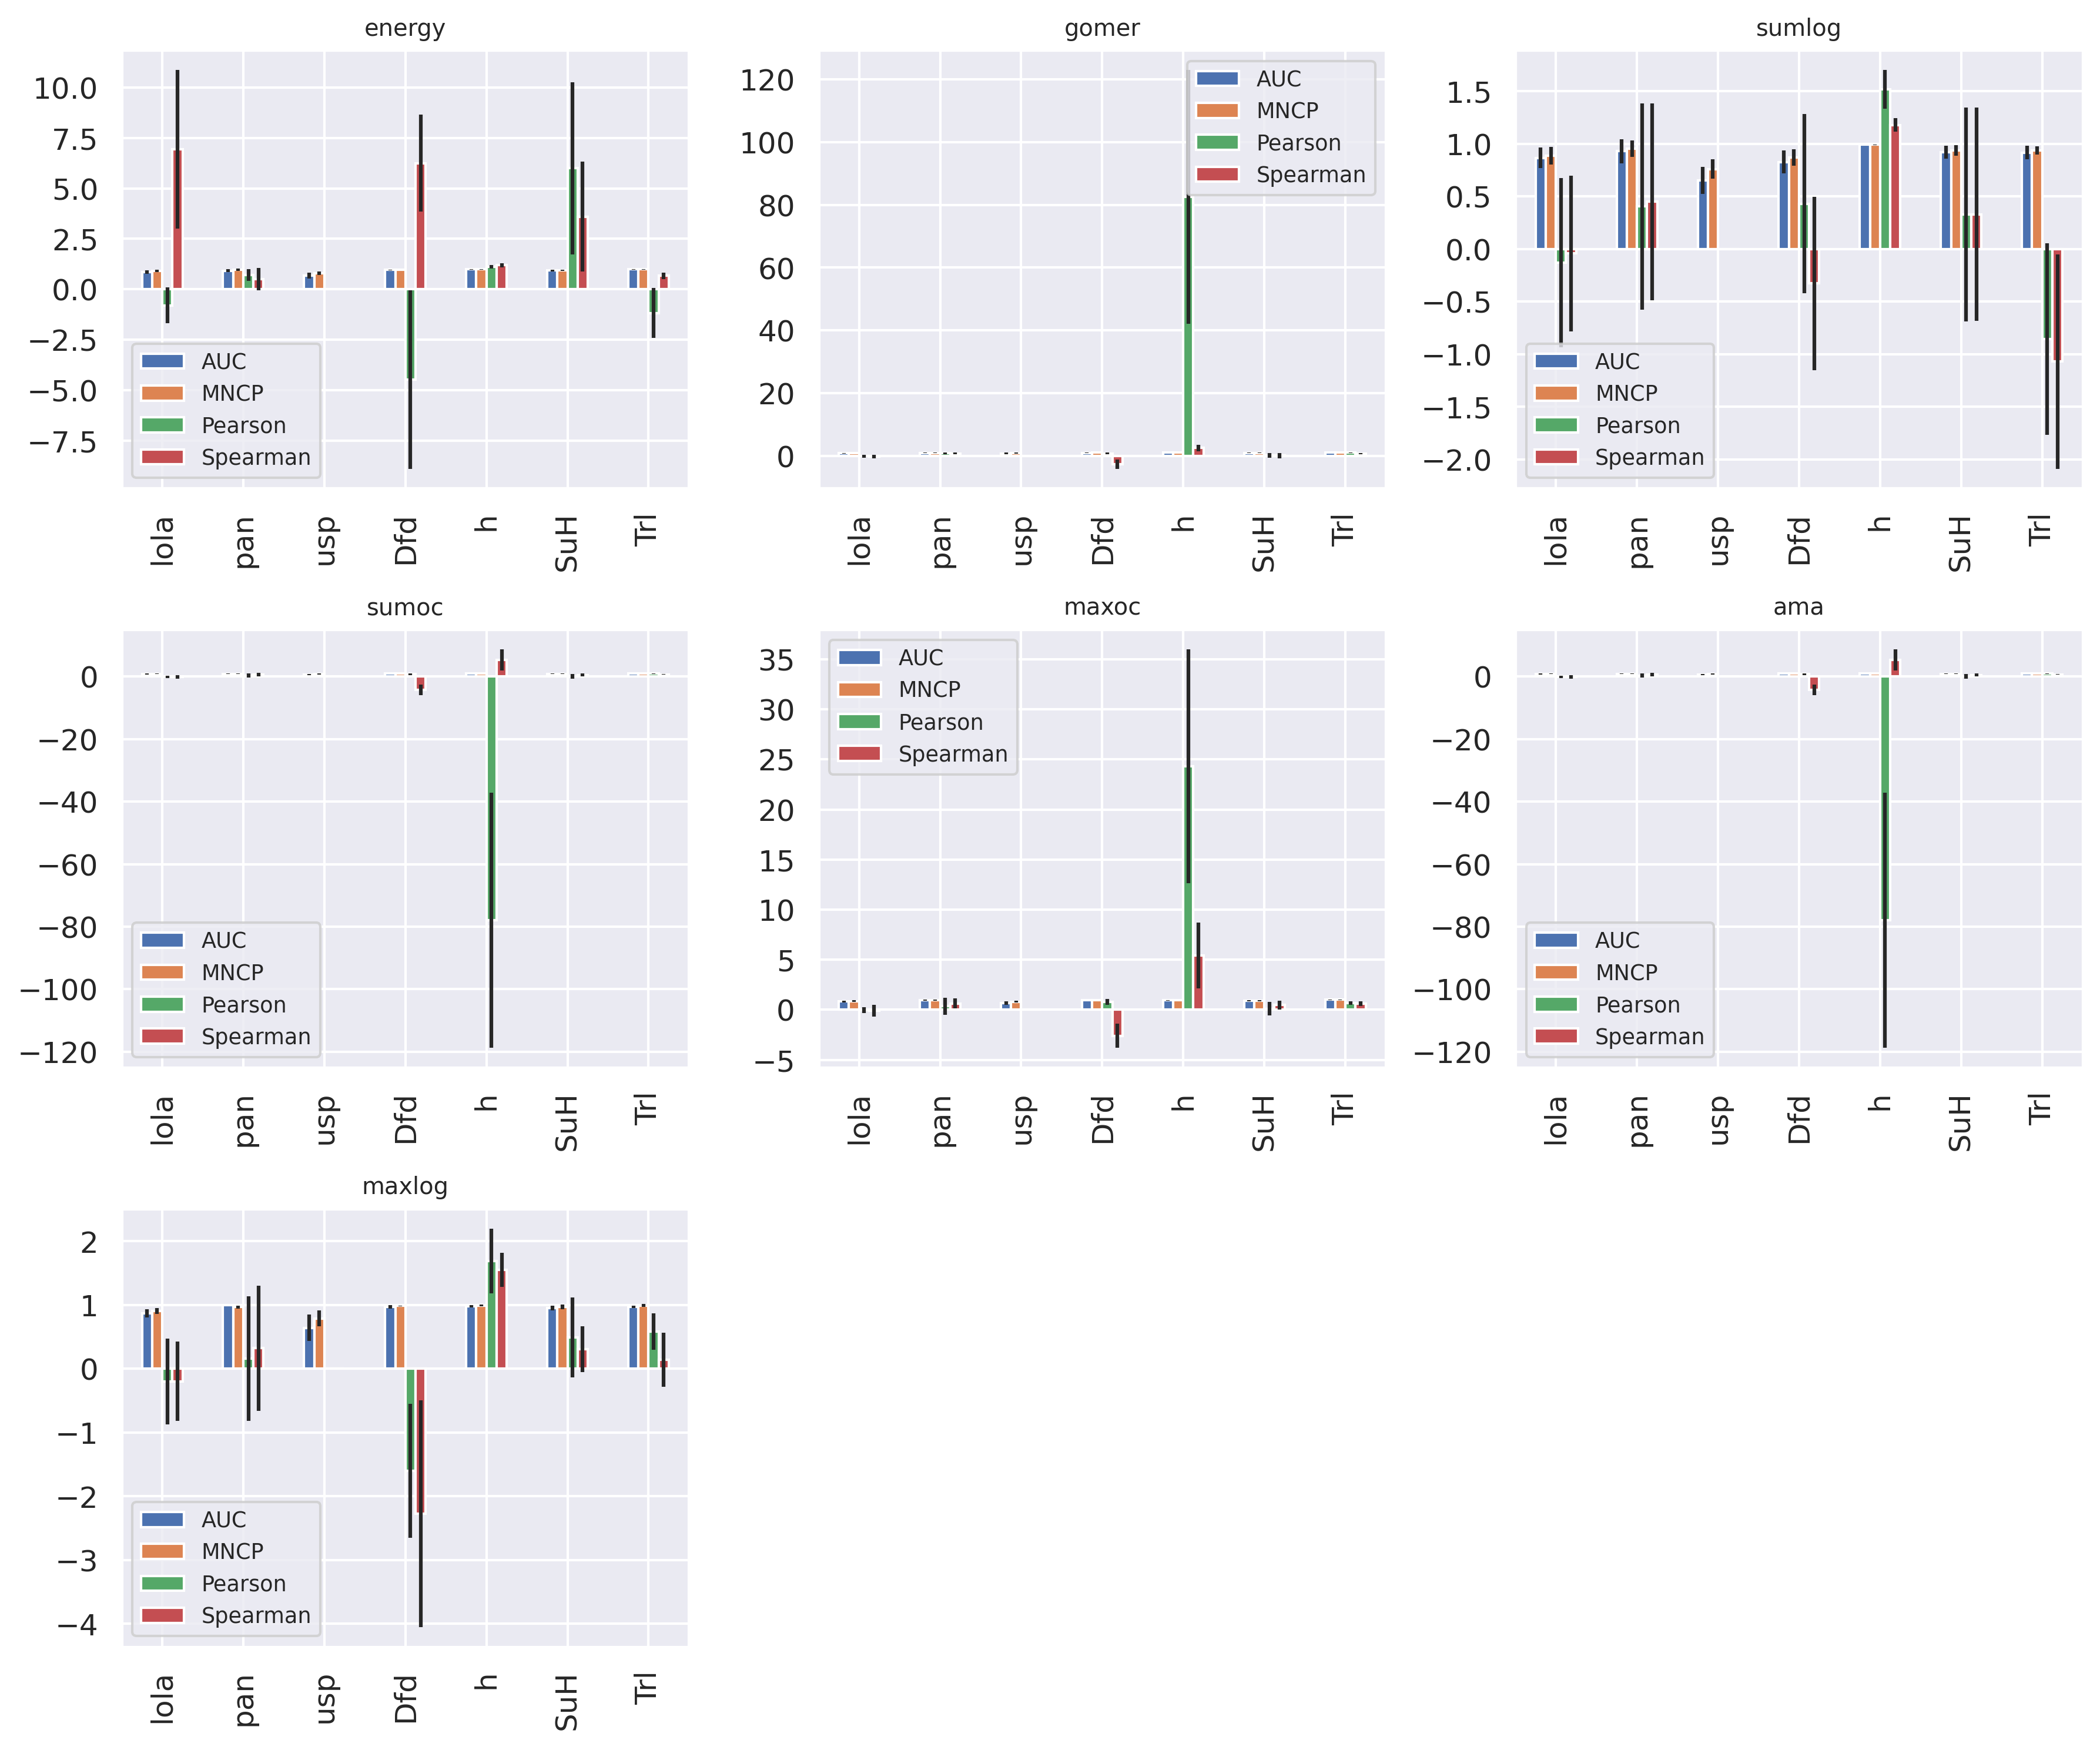

In [7]:
tf_list = ["lola", "pan", "usp", "Dfd", "h", "SuH", "Trl"]
score_list = ["energy", "gomer", "sumlog", "sumoc",	"maxoc", "ama", "maxlog"]

fig = plt.figure(figsize=(12,10),dpi=300)
ax1 = fig.add_subplot(3,3,1)
ax2 = fig.add_subplot(3,3,2)
ax3 = fig.add_subplot(3,3,3)
ax4 = fig.add_subplot(3,3,4)
ax5 = fig.add_subplot(3,3,5)
ax6 = fig.add_subplot(3,3,6)
ax7 = fig.add_subplot(3,3,7)

for c,score in enumerate(score_list):
    #print(f"Effects of statistics on motif ranking using {score} scoring")
    c +=1
    tf = tf_list[0]
    chip = pd.read_table('Results/%s/%s.%s' % (tf, tf, score), index_col='Motif')
    chip = chip/chip.max()
    chip_std = chip.std().to_frame(name=tf).T
    chip_mean = np.mean(chip).to_frame(name=tf)
    chip_mean_test = chip_mean.T
    rank_sum = ranksums(chip['AUC'],chip['Spearman'])[1] # compute wilcoxon rank-sum test

    for tf in tf_list[1:]:
        chip = pd.read_table('Results/%s/%s.%s' % (tf, tf, score), index_col='Motif')
        chip = chip/chip.max()
        #print tf
        rank_sum += ranksums(chip['AUC'],chip['Spearman'])[1]
        chip_s = chip.std().to_frame(name=tf)
        chip_std = chip_std.append(chip_s.T)
        chip_mean = np.mean(chip).to_frame(name=tf)

        chip_mean_test = chip_mean_test.append(chip_mean.T)

    ax = fig.add_subplot(3,3,c)
    chip_mean_test.plot(kind='bar',yerr=chip_std, figsize=(12,10),
                             title=(f"{score}"), fontsize=12, ax = ax)
    #ax.grid(False)
fig.tight_layout()
#     ax.set_xlabel("Transcription factors")
#     ax.set_ylabel("Normalized scores")
#     #ax.set_axis_bgcolor('W')
#     fig = ax.get_figure()


## View individual large plots

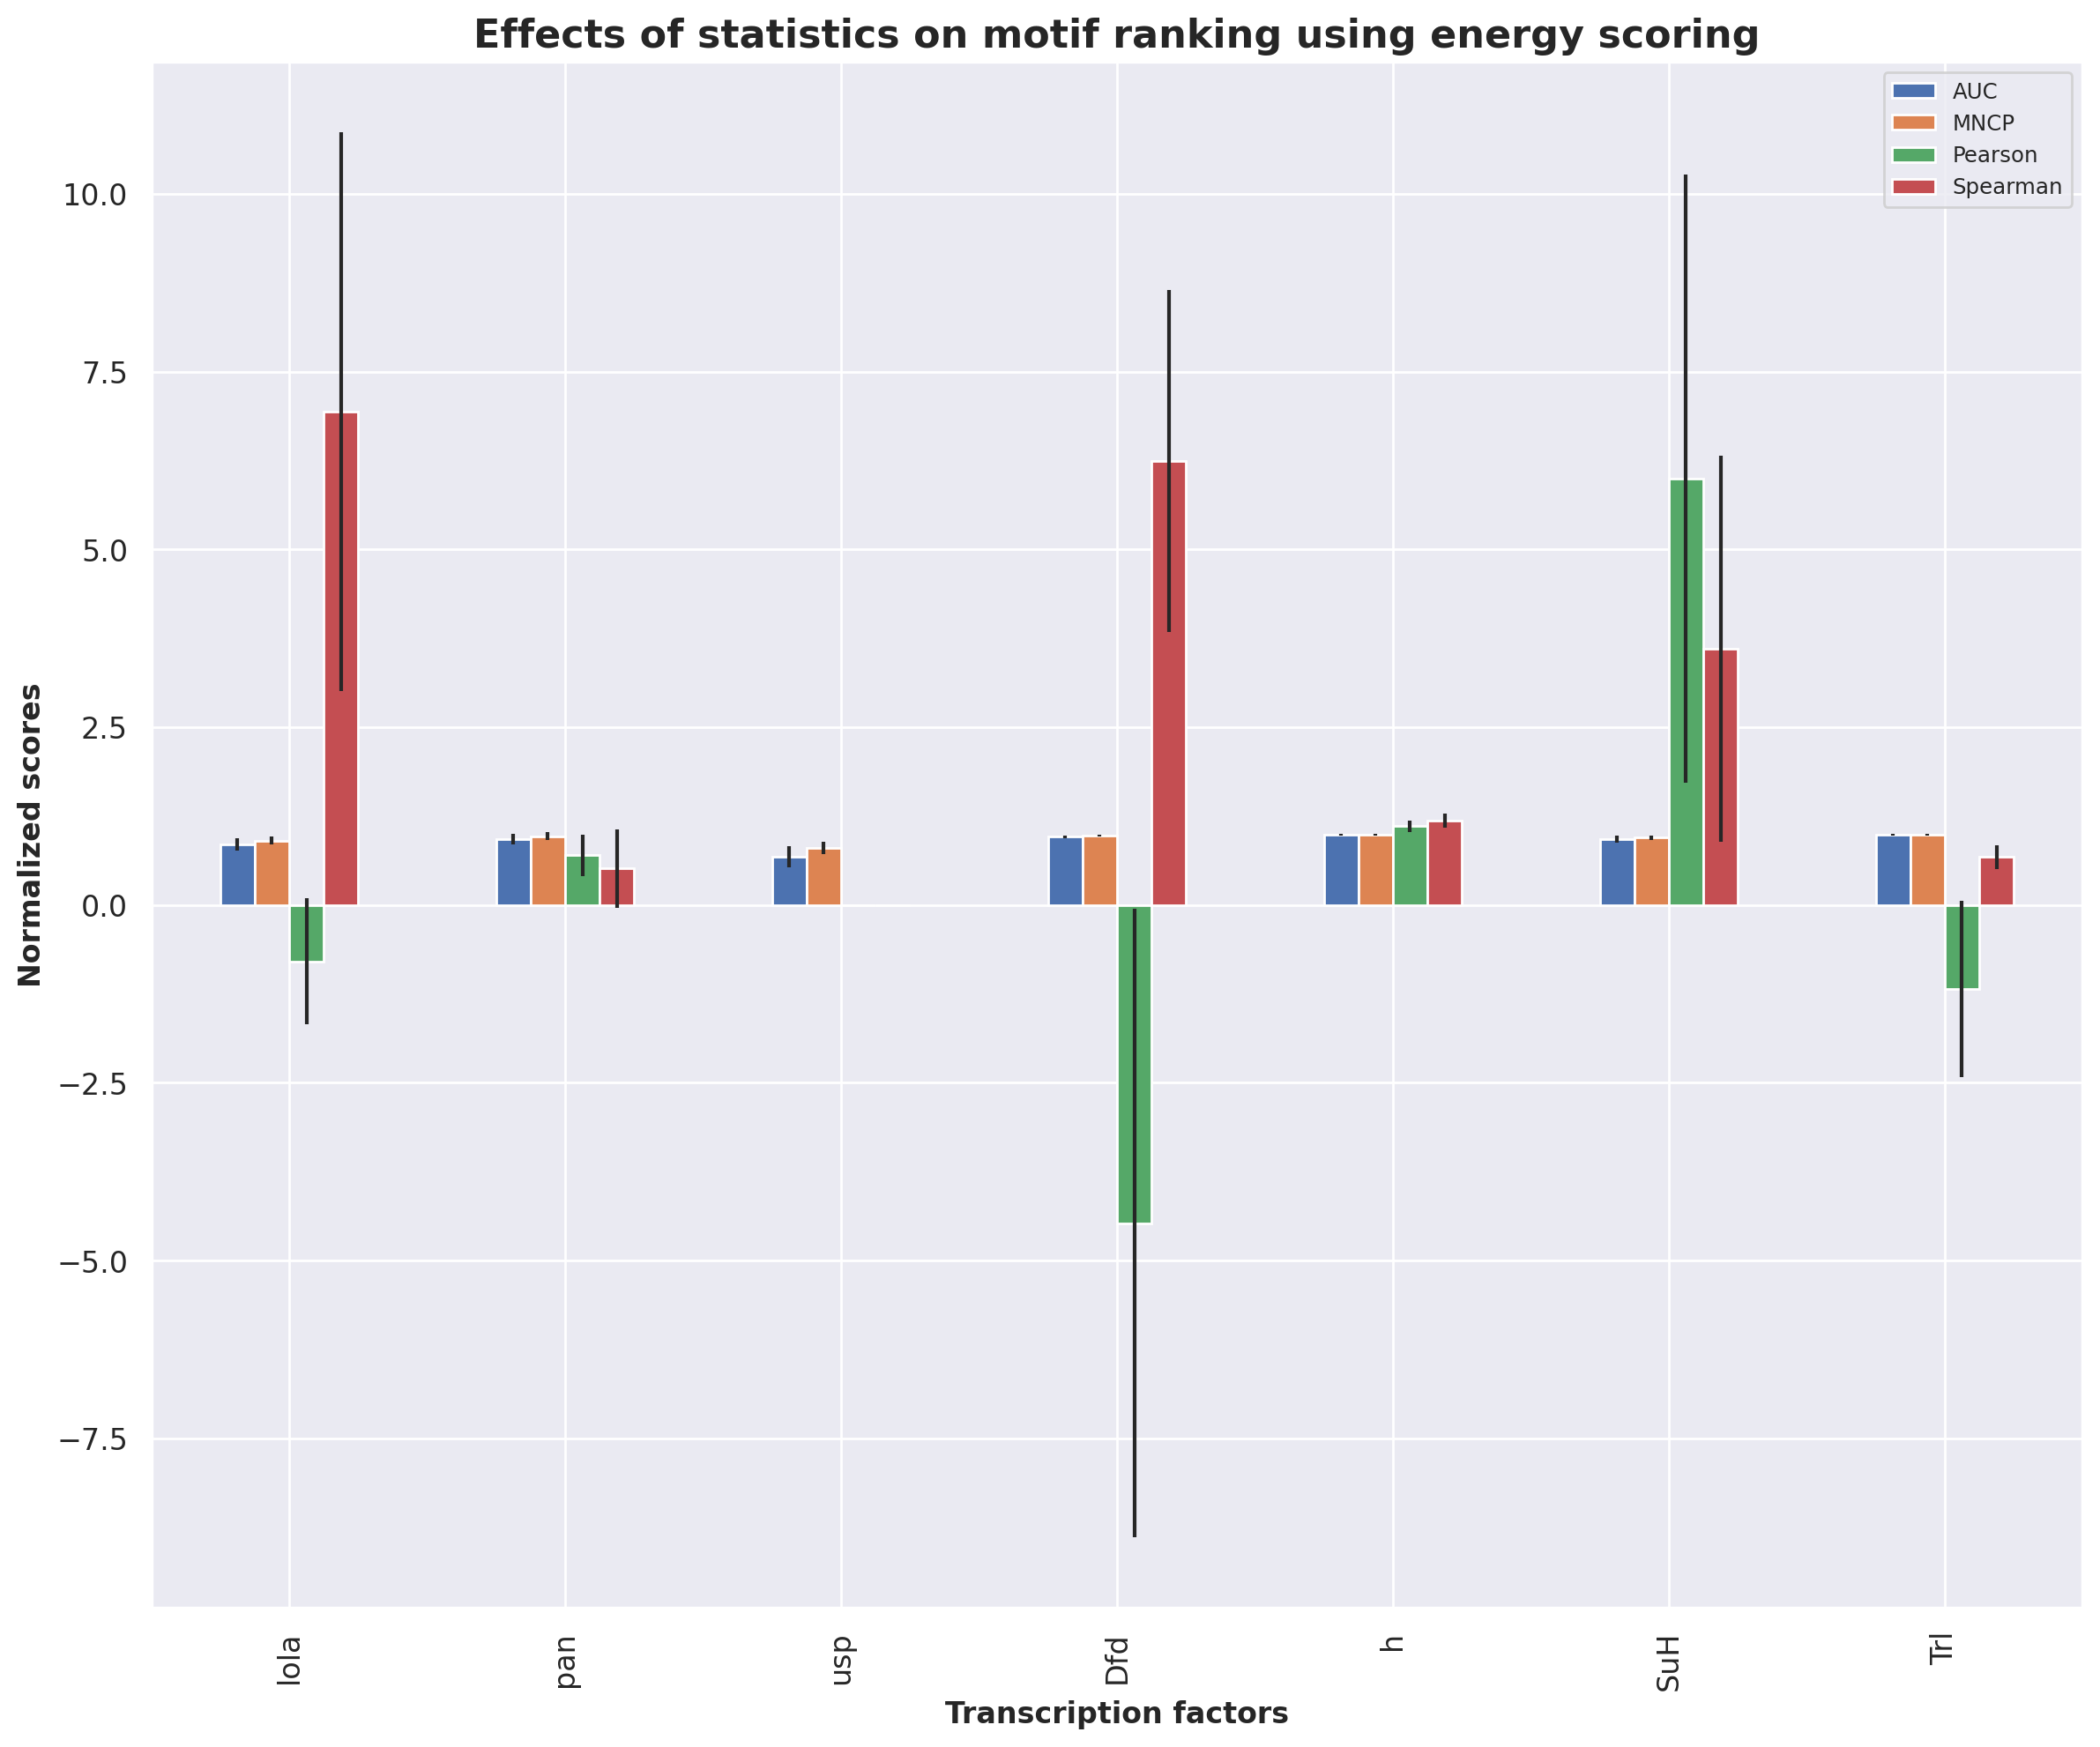

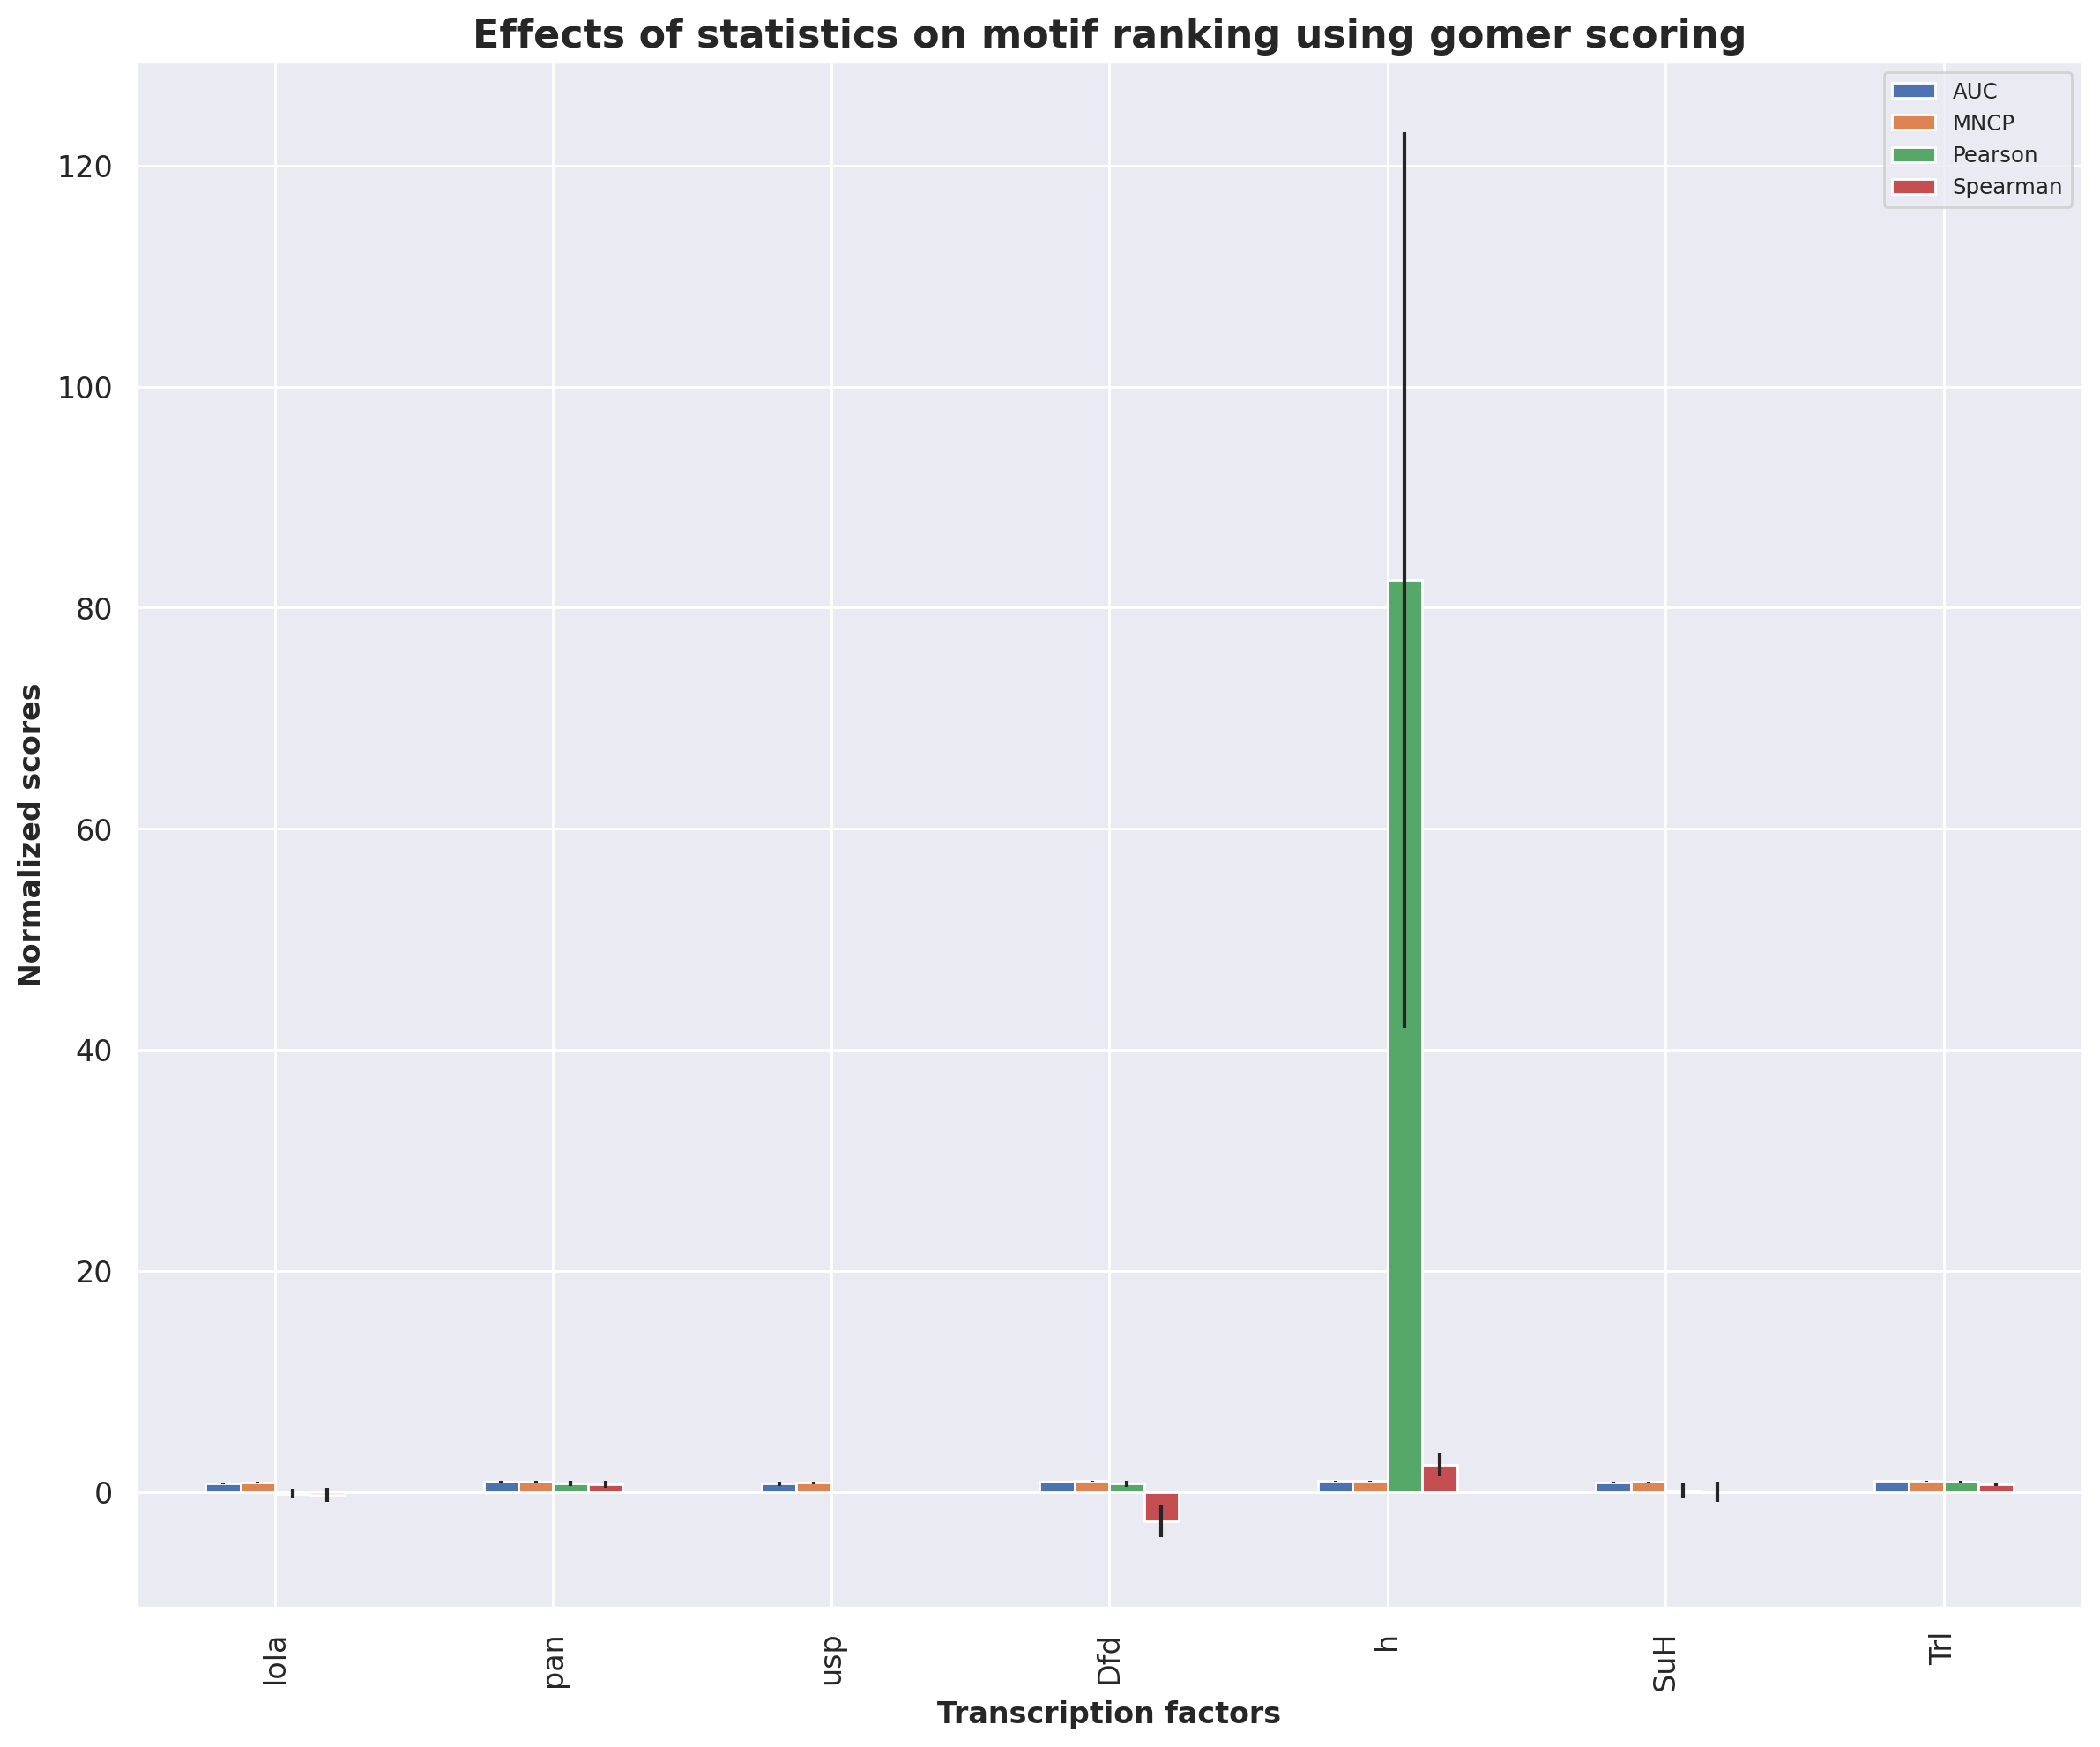

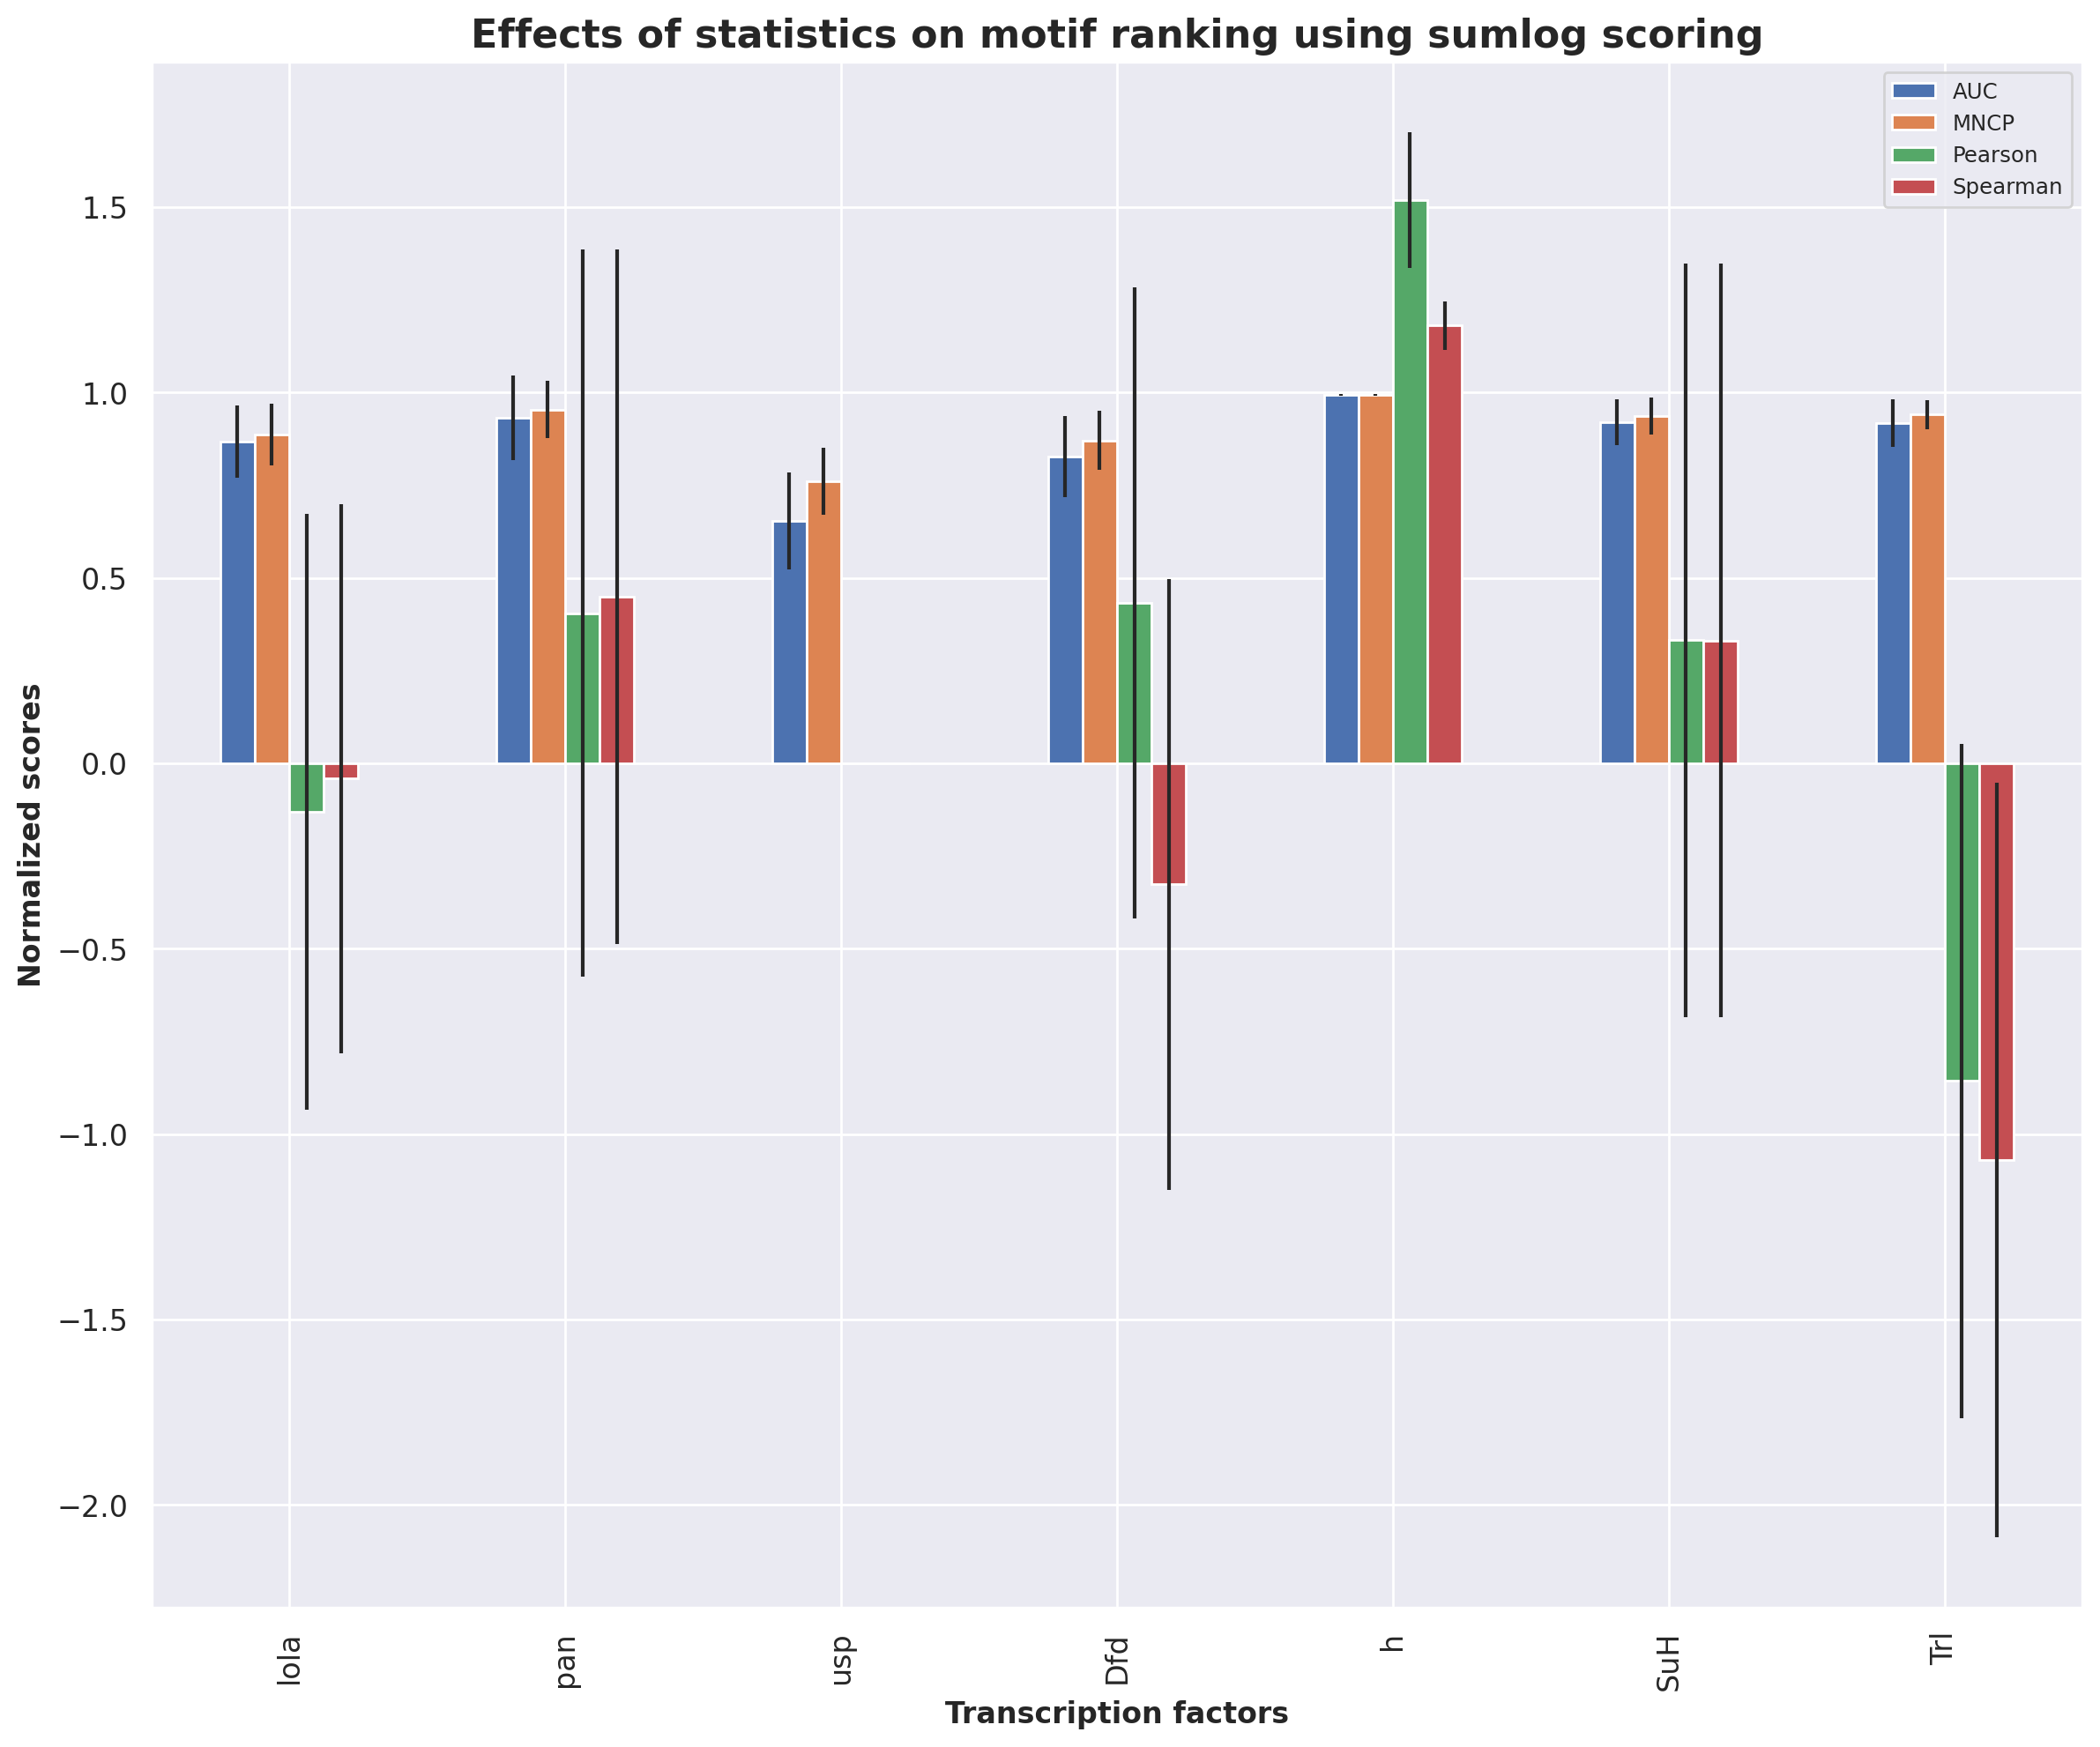

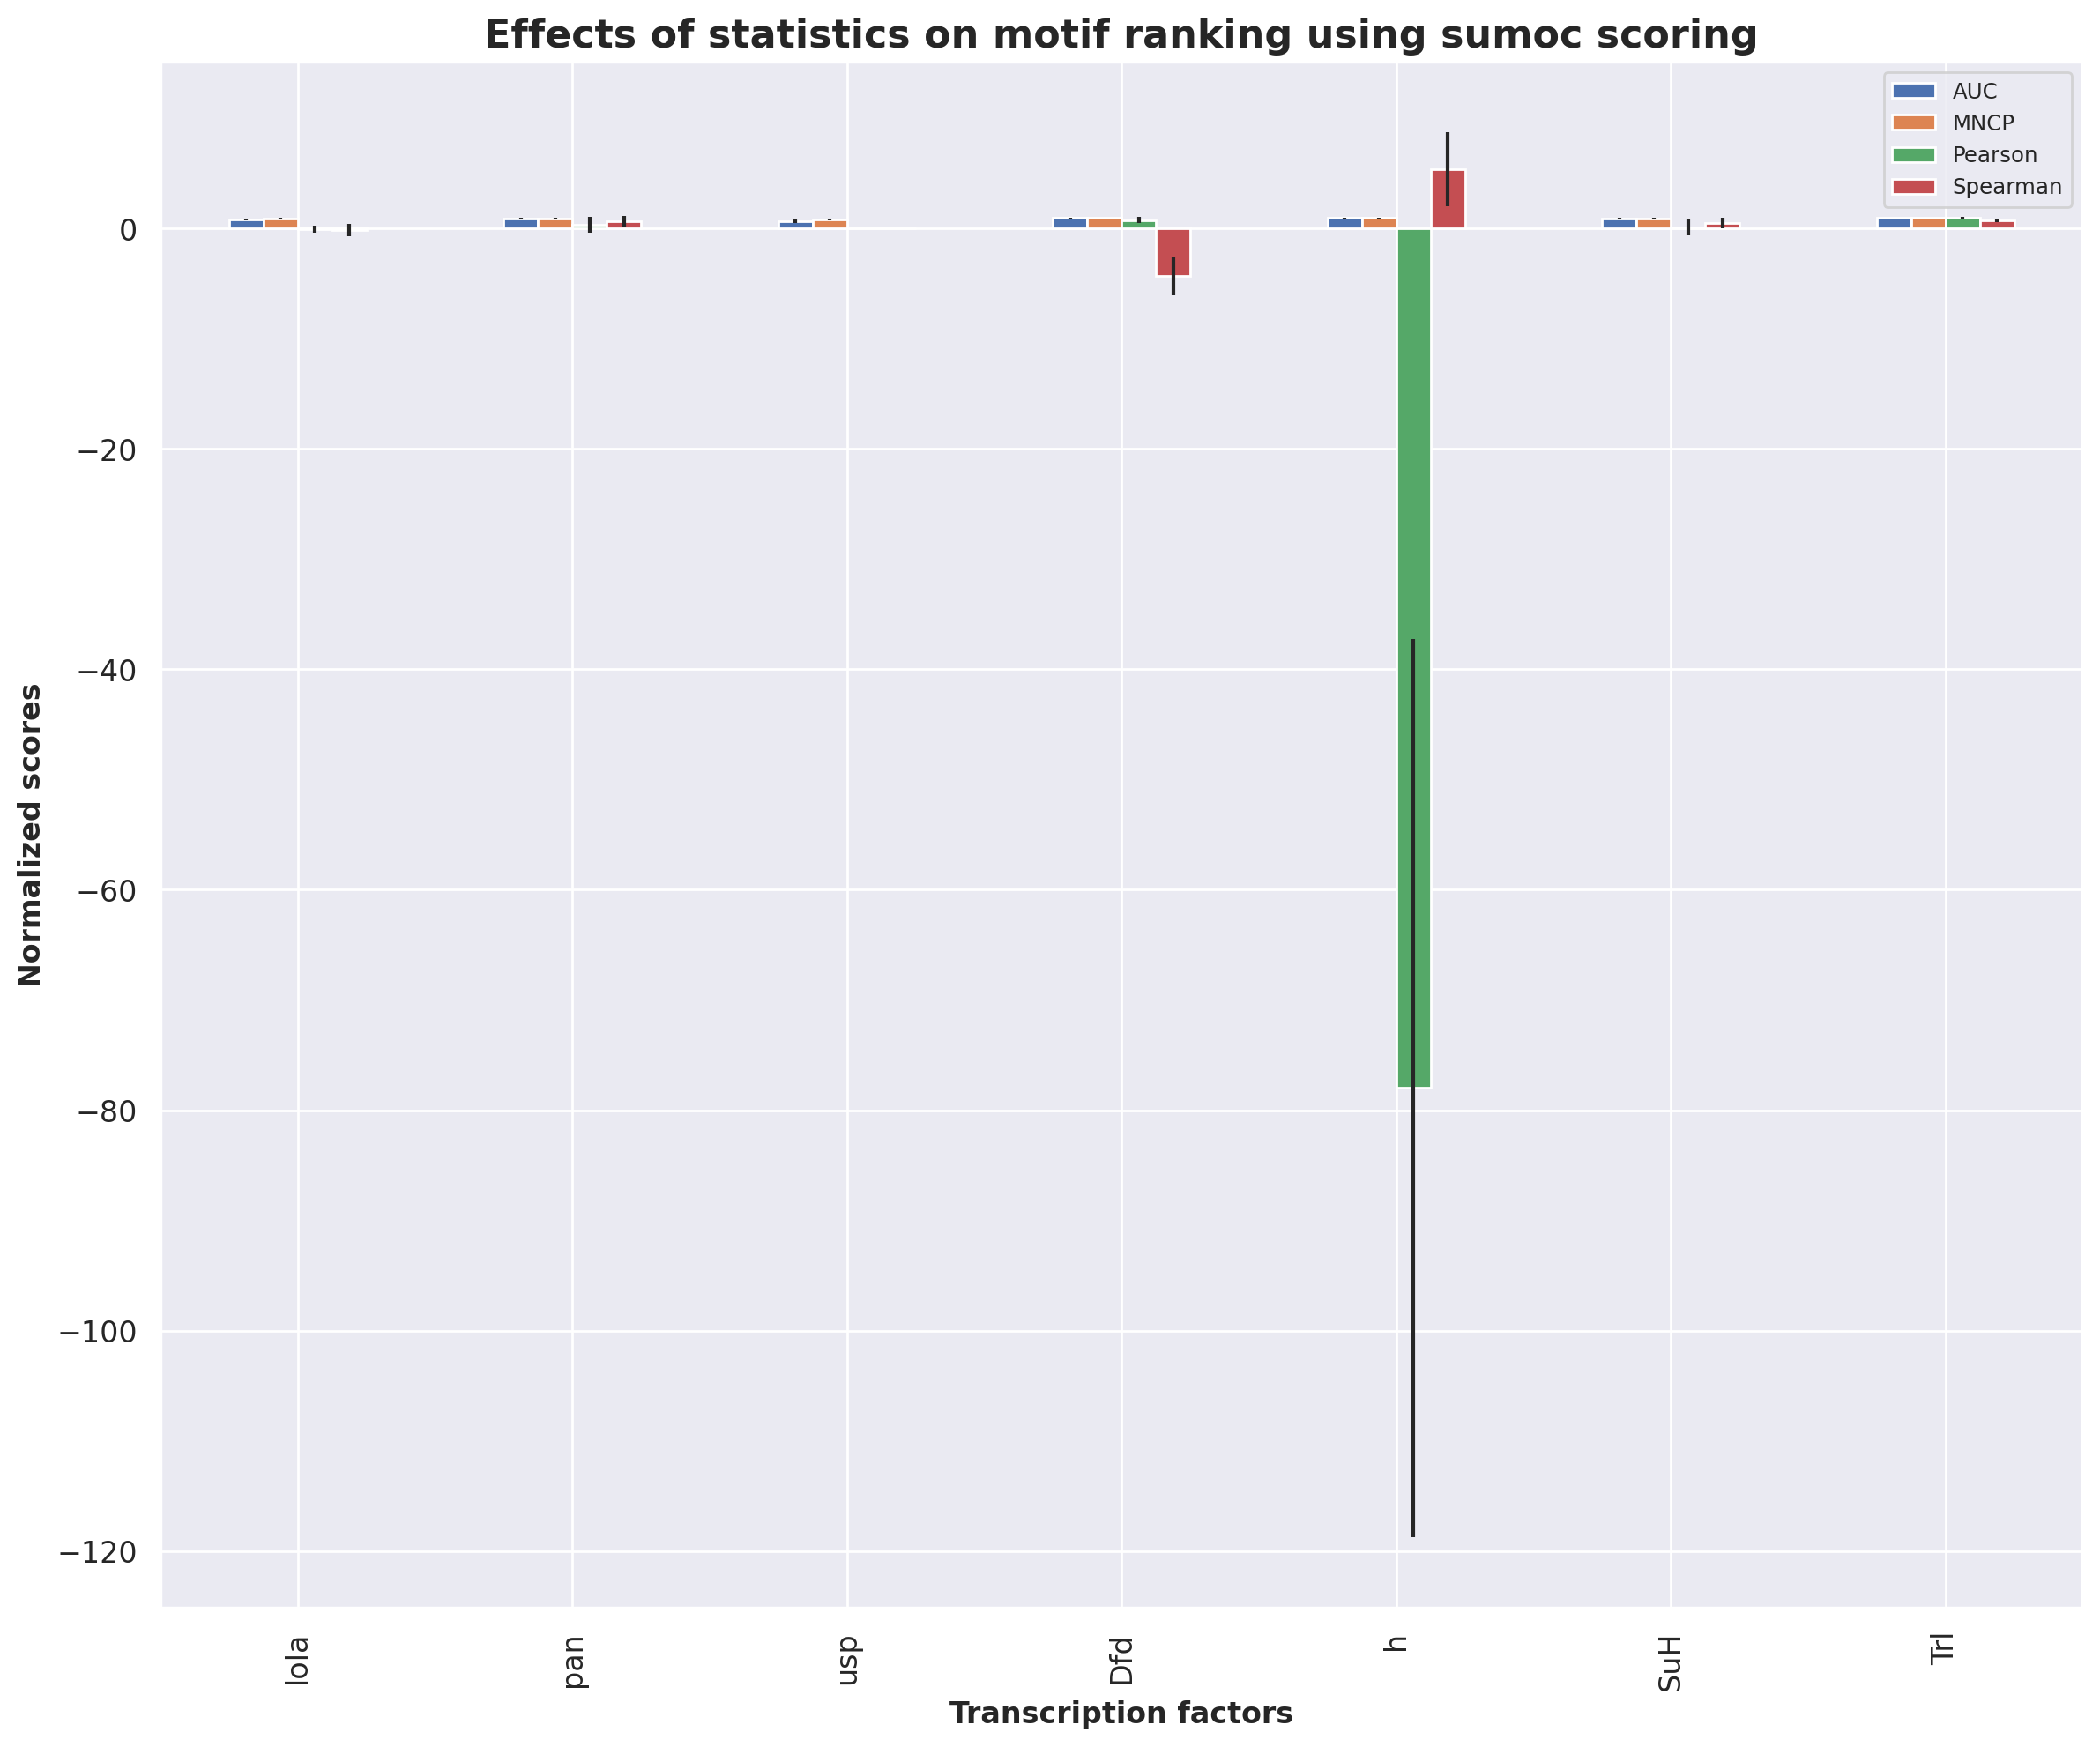

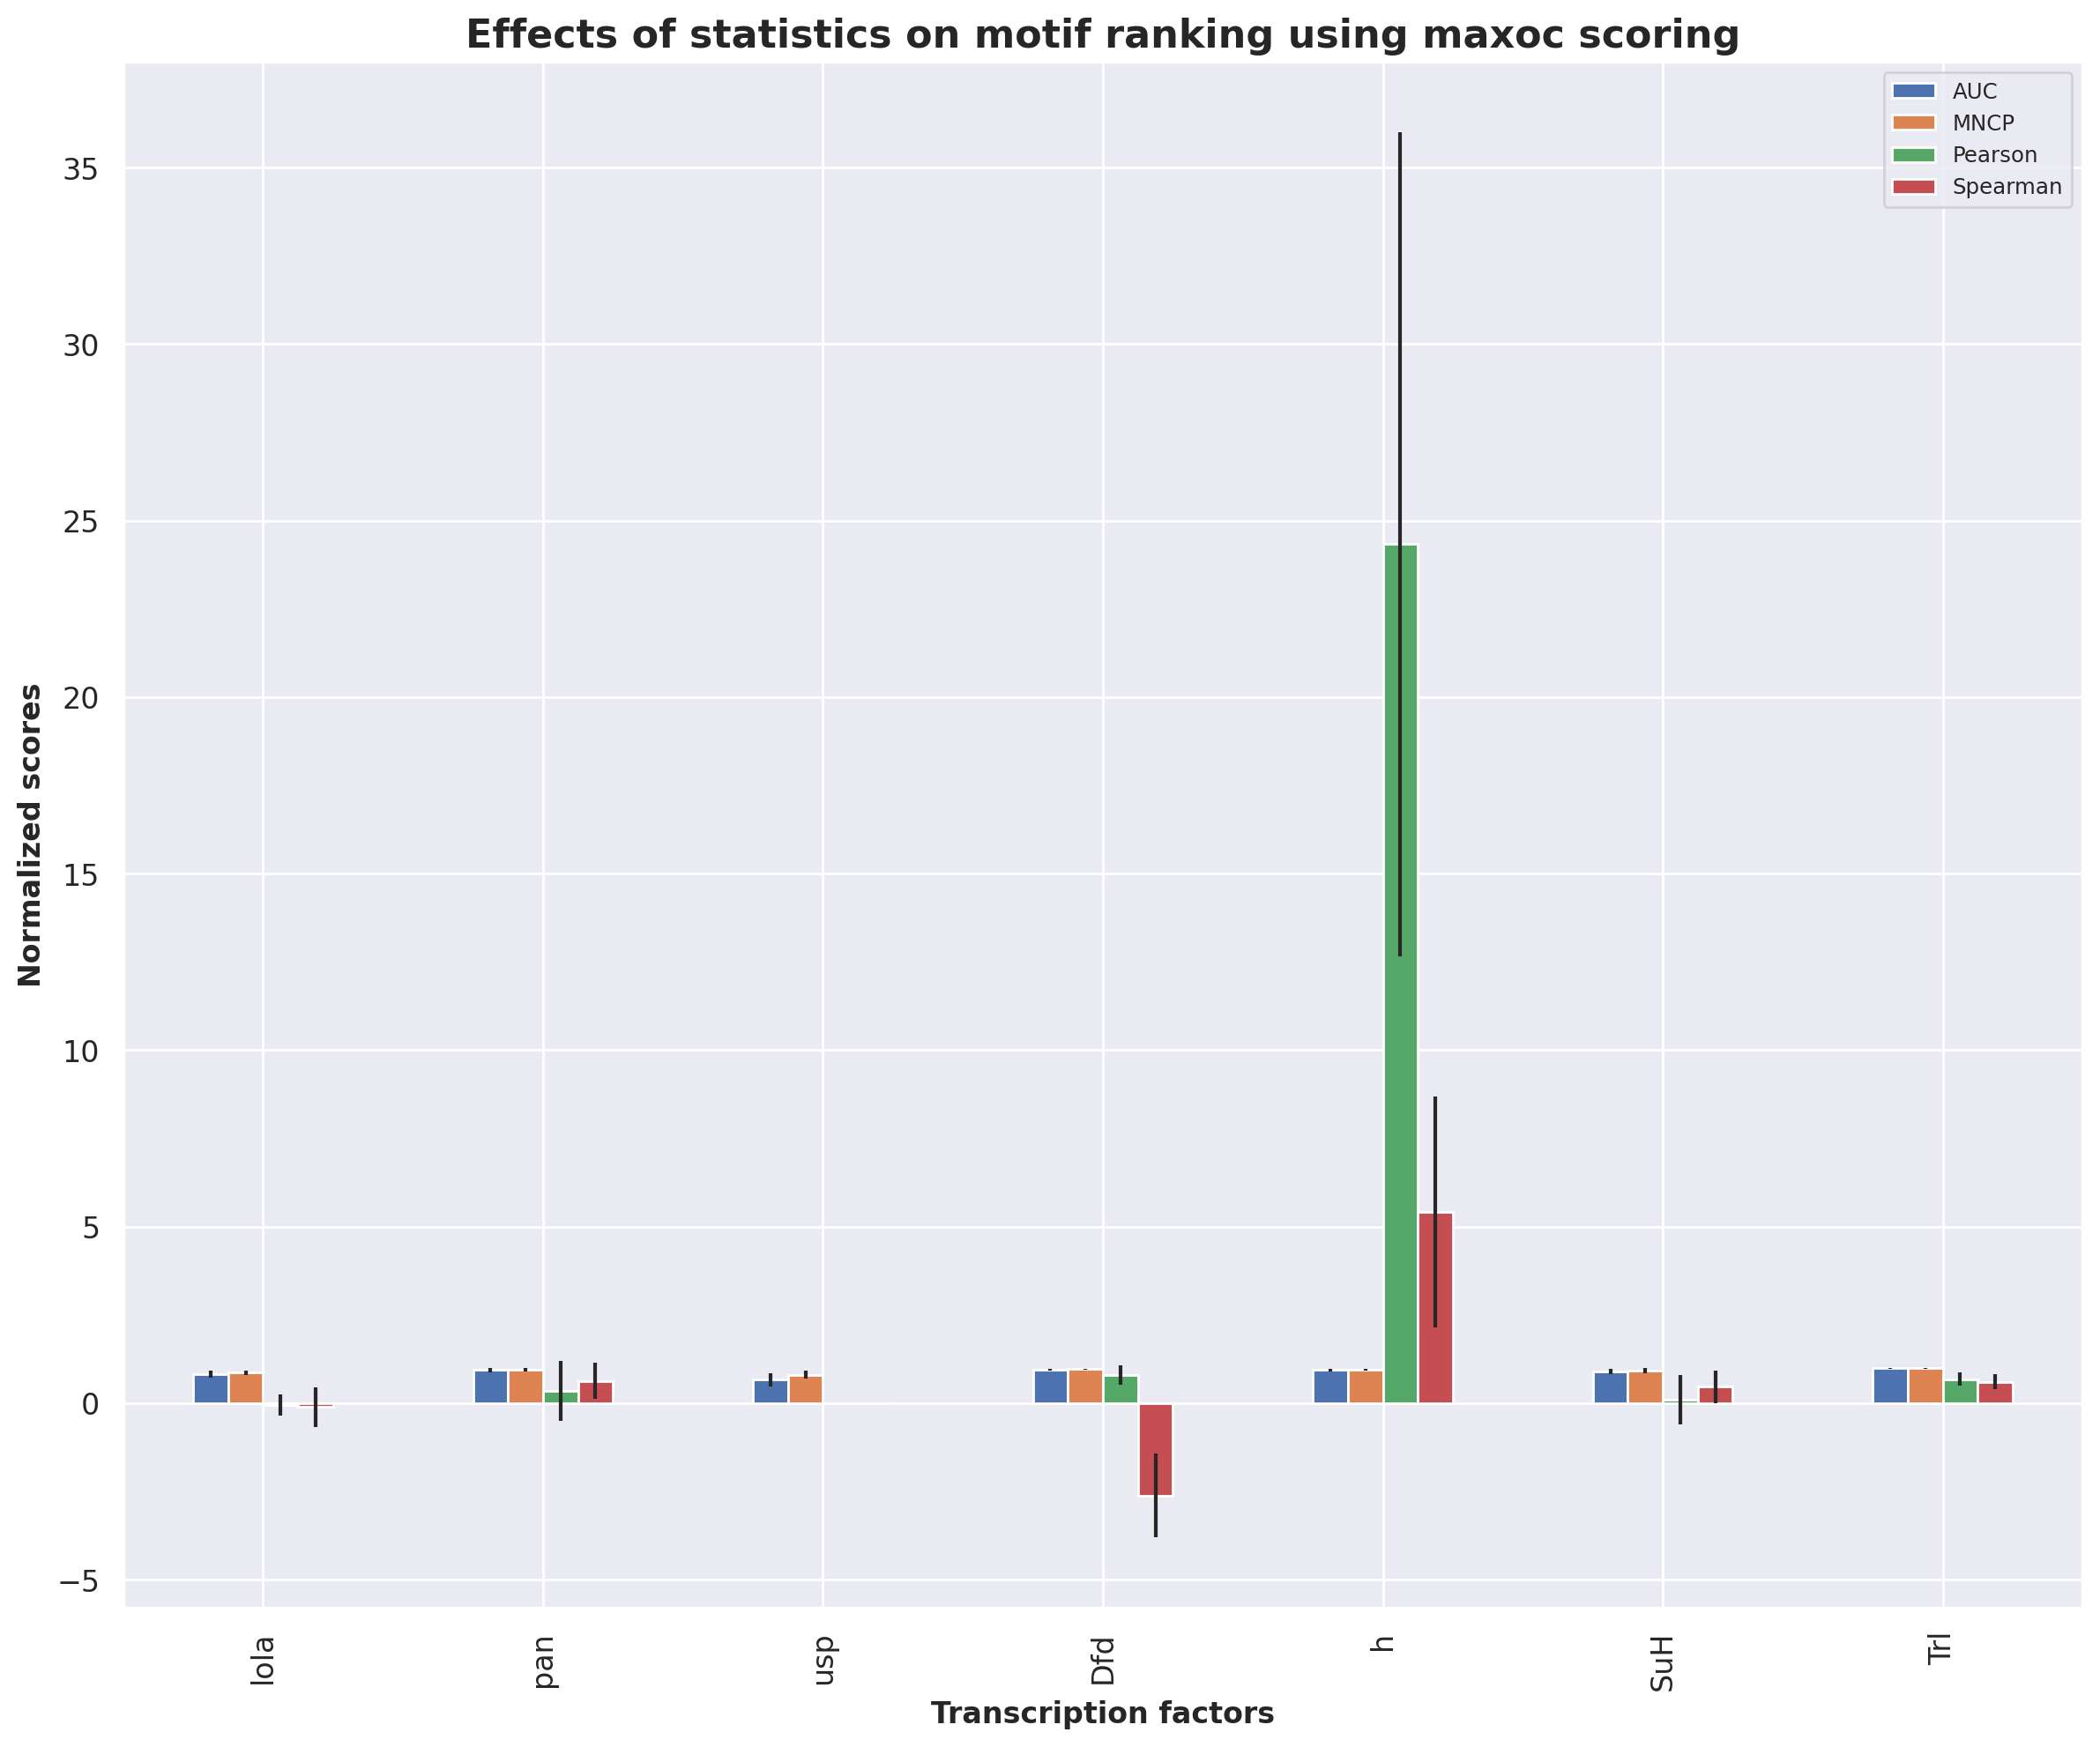

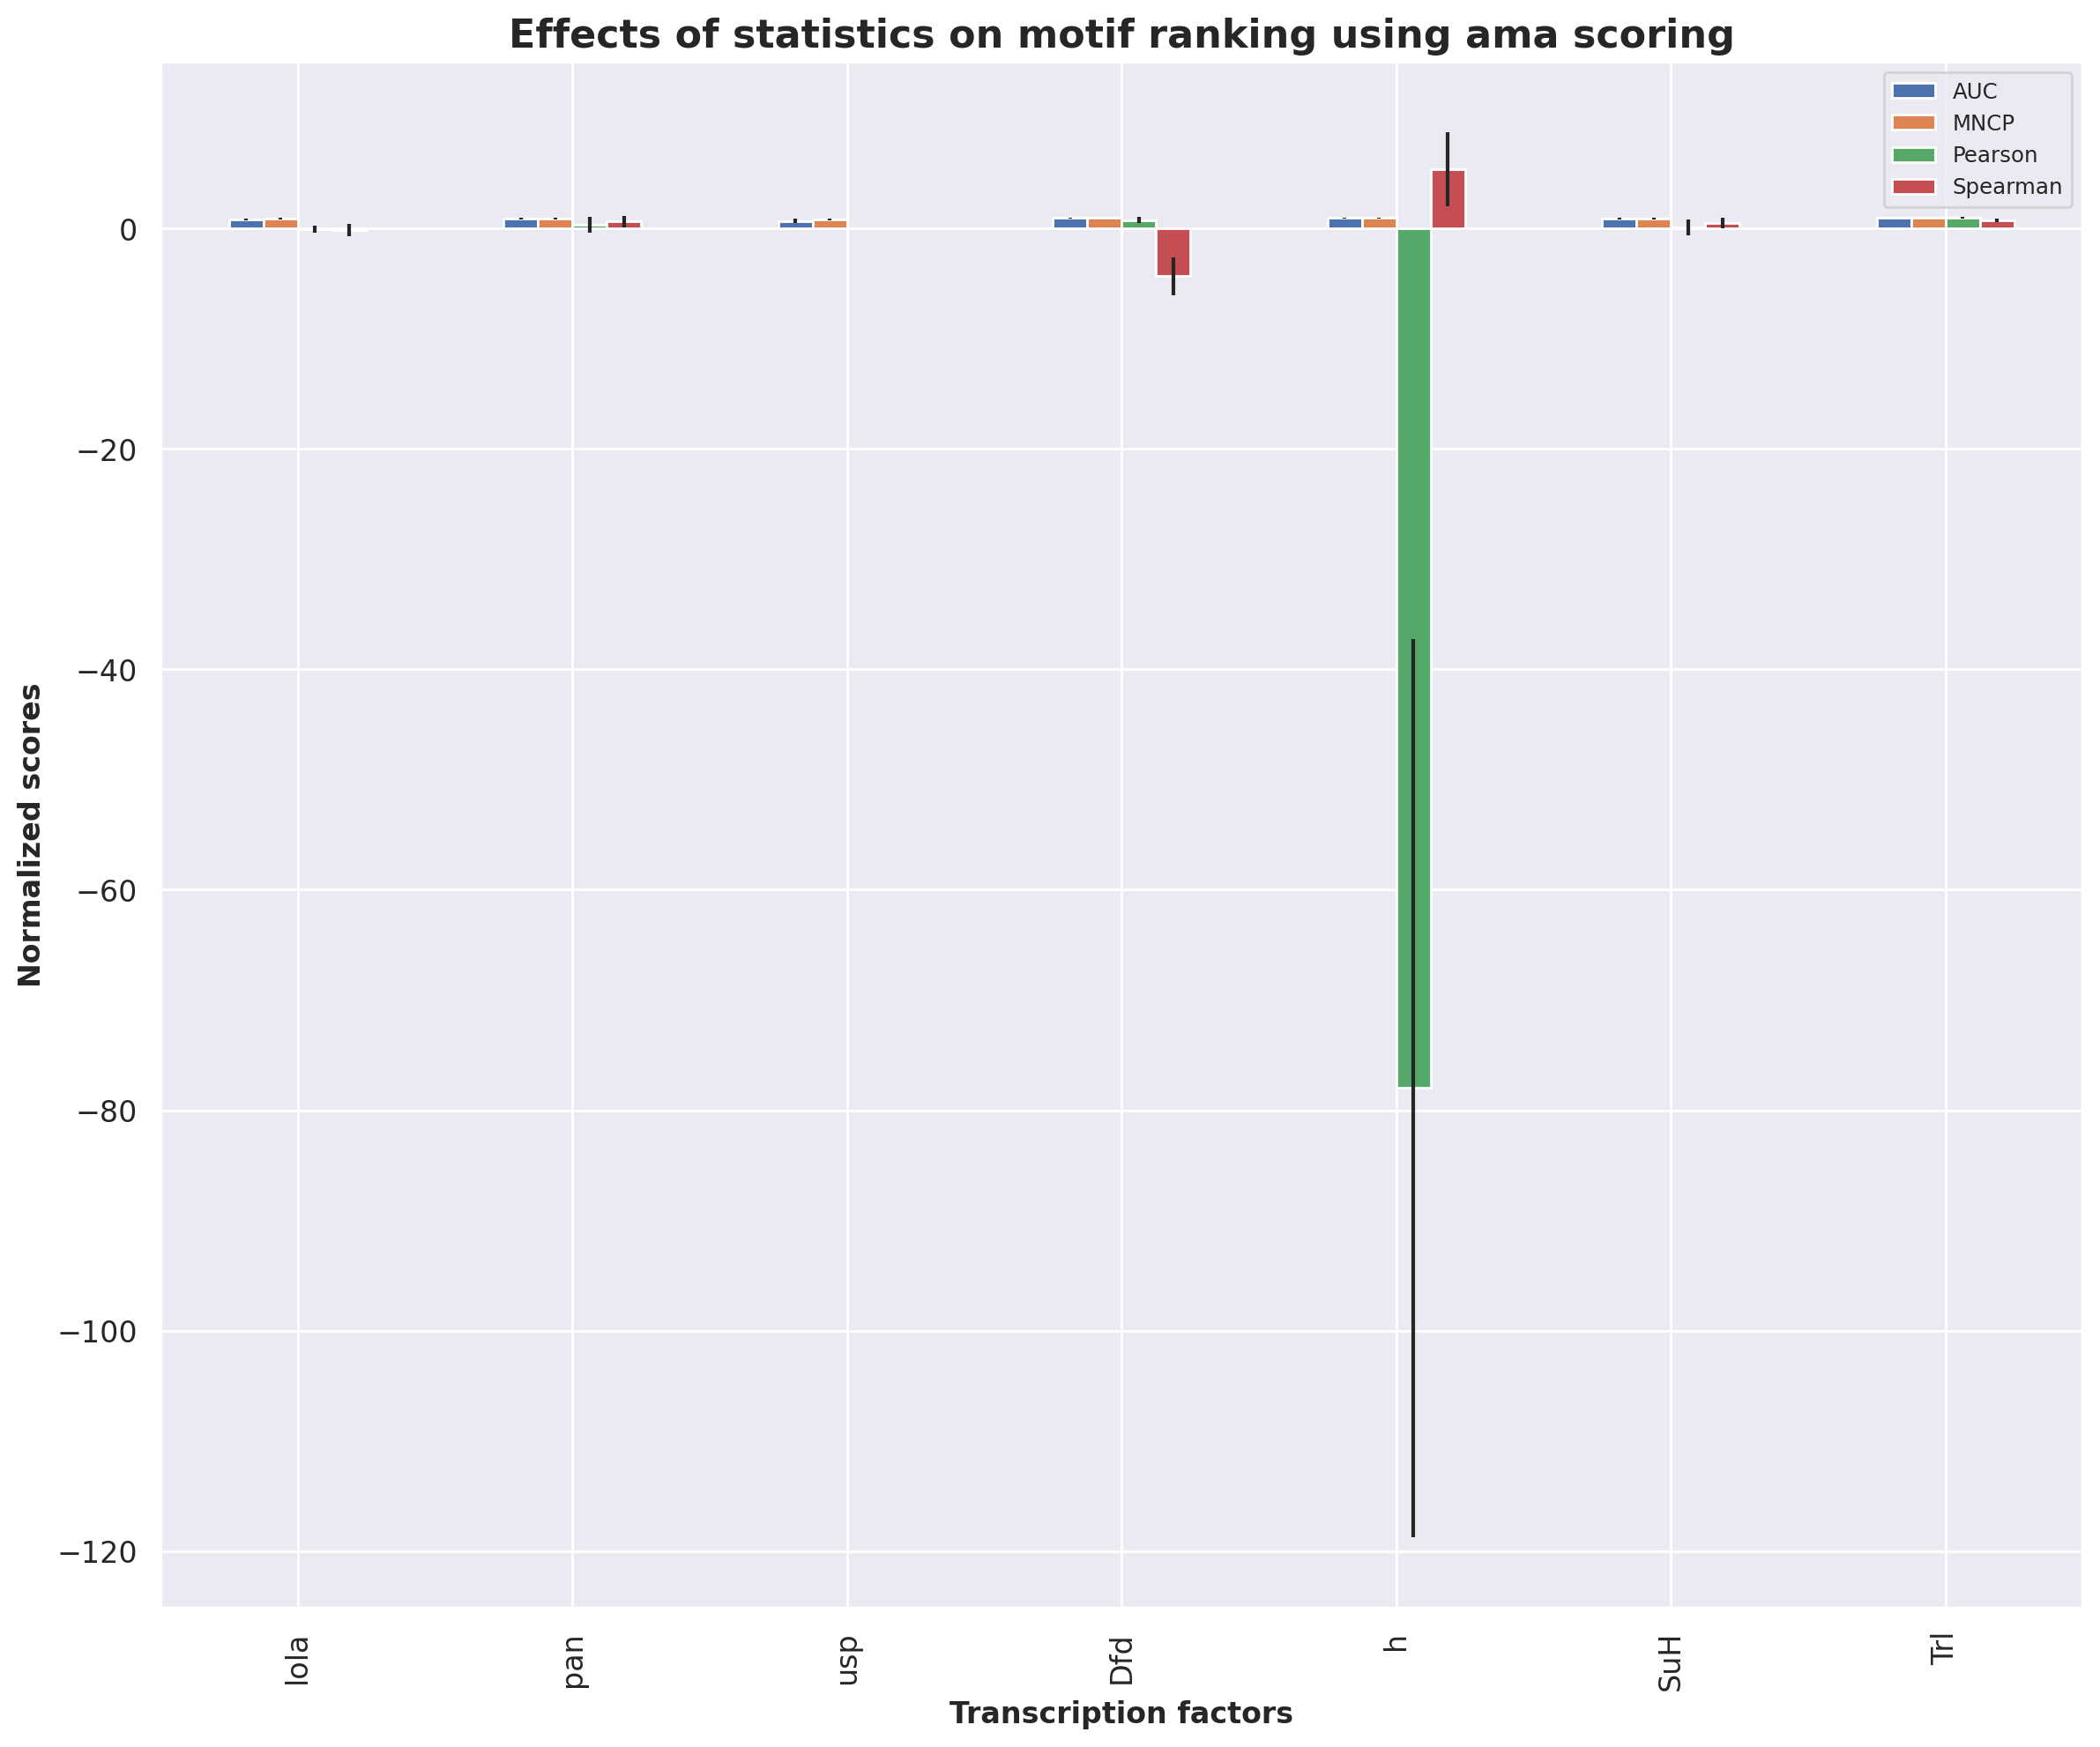

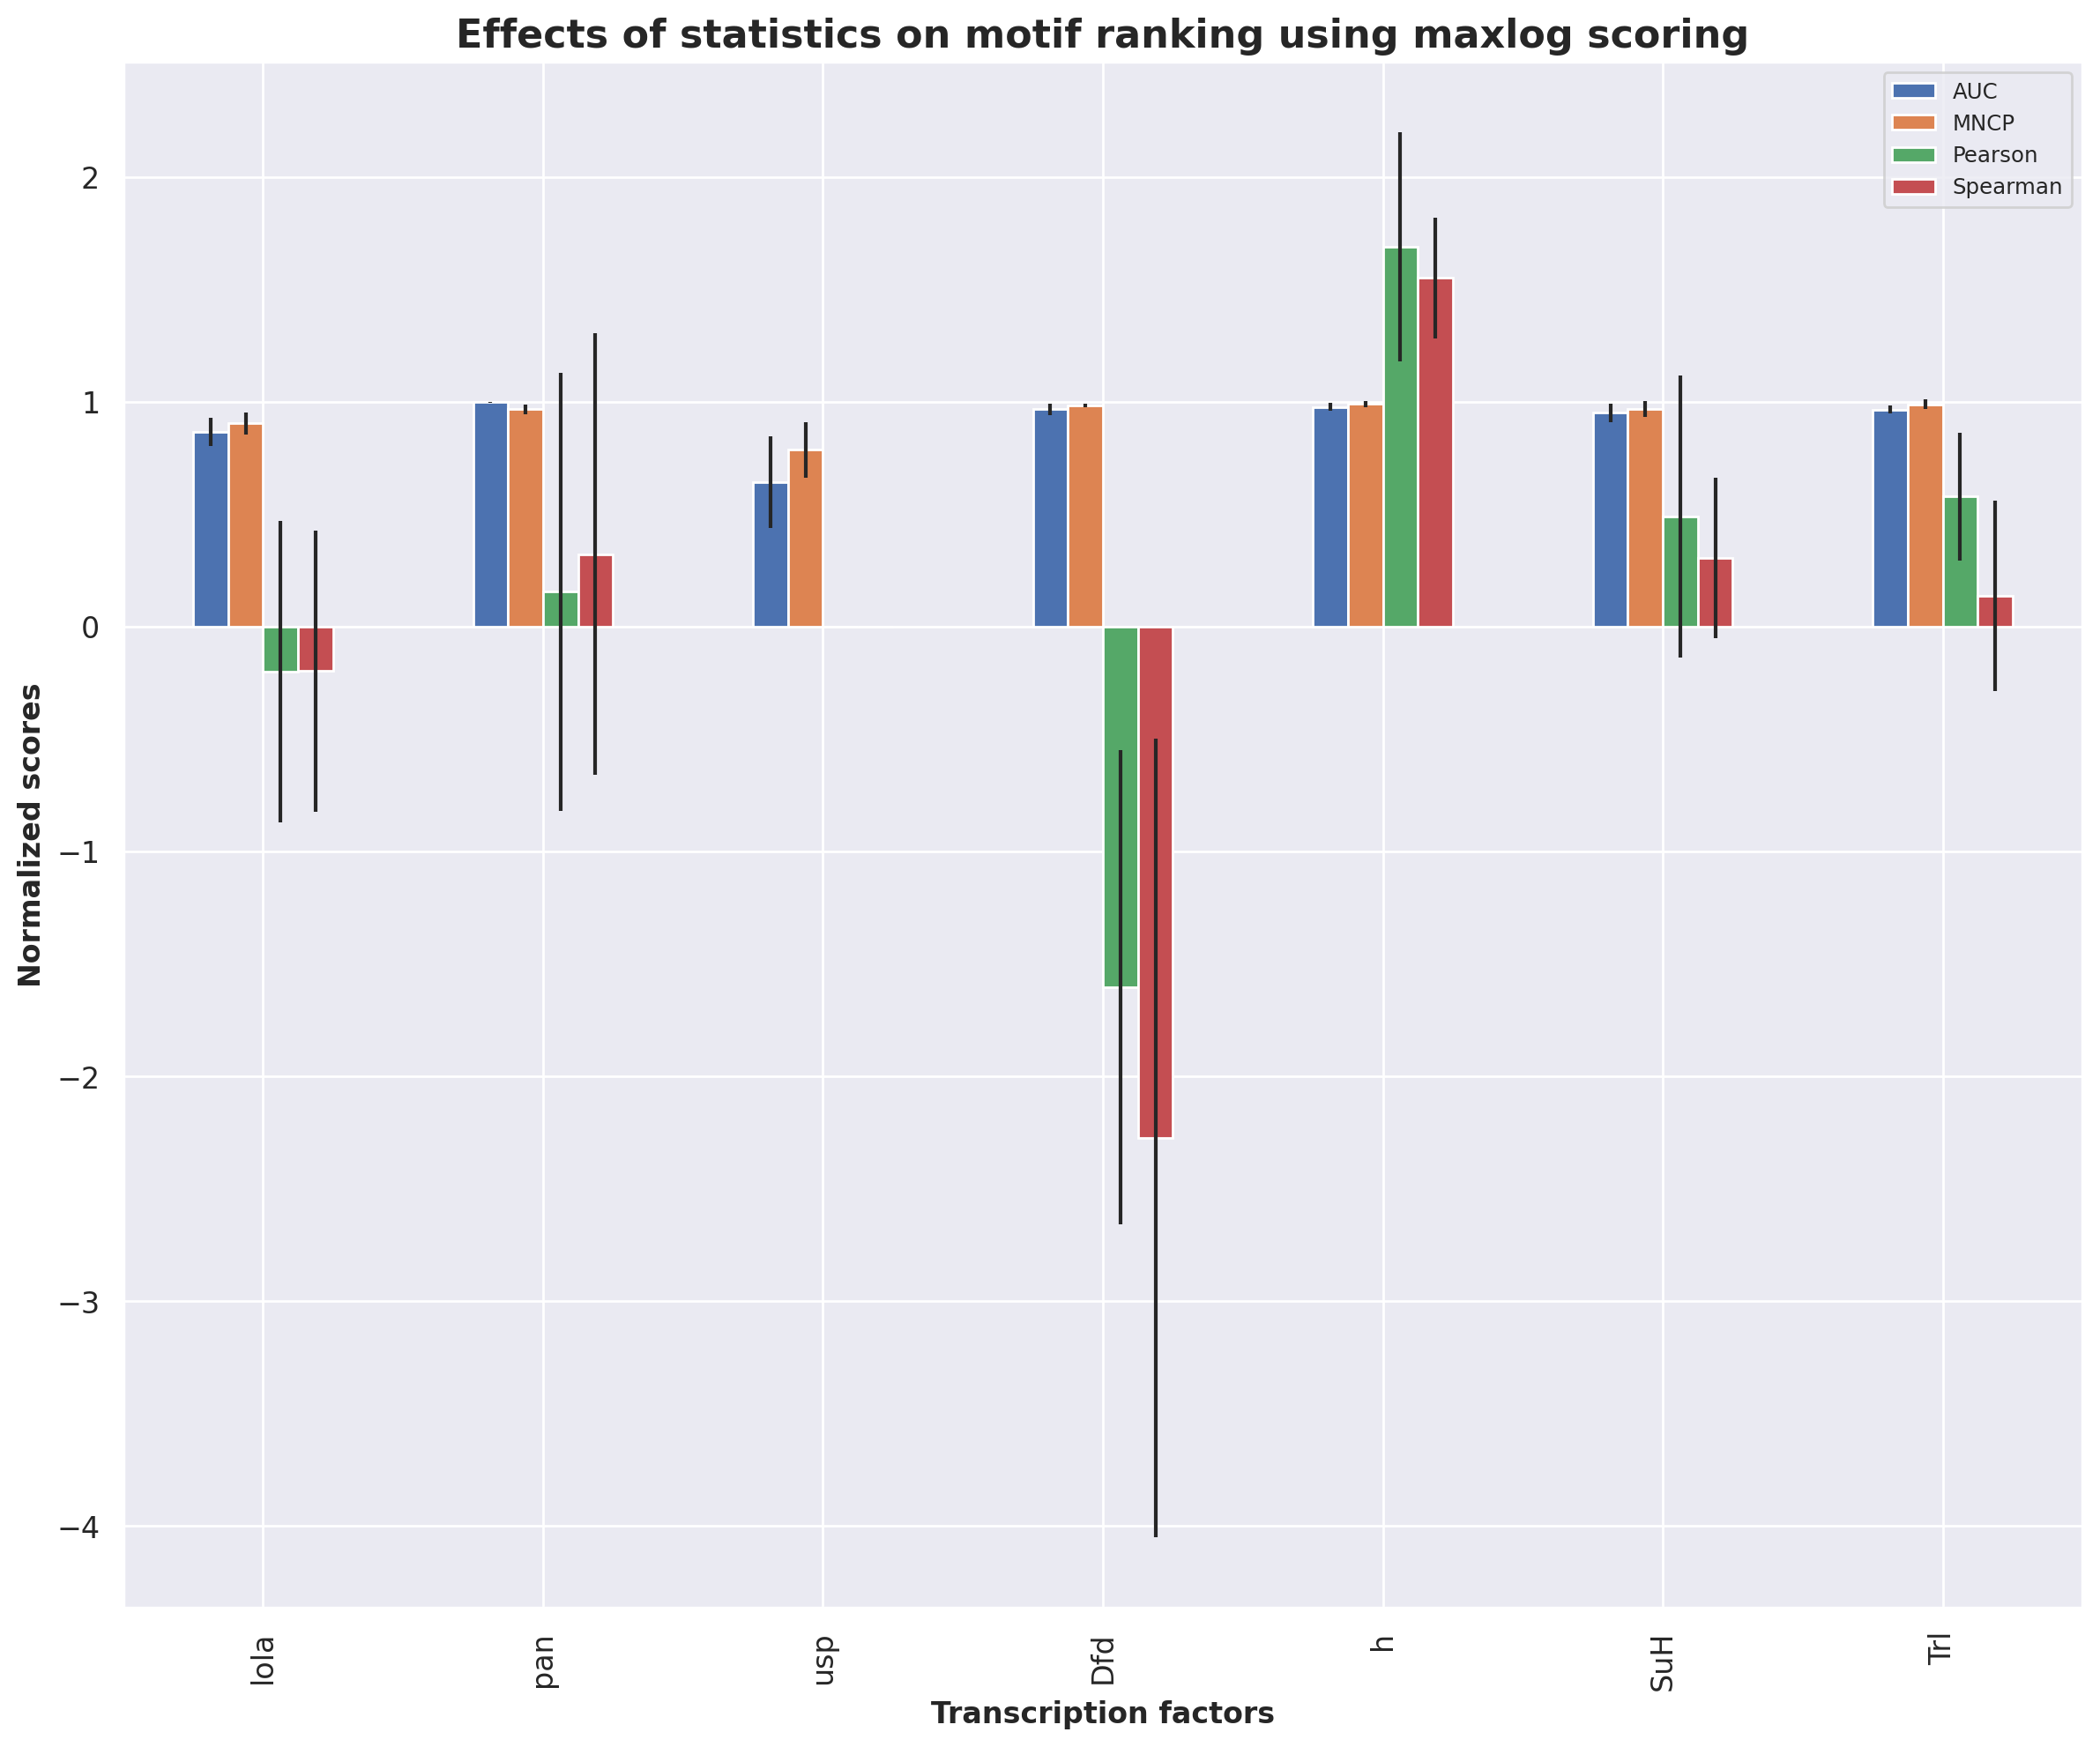

In [8]:
tf_list = ["lola", "pan", "usp", "Dfd", "h", "SuH", "Trl"]
score_list = ["energy", "gomer", "sumlog", "sumoc",	"maxoc", "ama", "maxlog"]

for score in score_list:
    #print(f"Effects of statistics on motif ranking using {score} scoring")

    tf = tf_list[0]
    chip = pd.read_table('Results/%s/%s.%s' % (tf, tf, score), index_col='Motif')
    chip = chip/chip.max()
    chip_std = chip.std().to_frame(name=tf).T
    chip_mean = np.mean(chip).to_frame(name=tf)
    chip_mean_test = chip_mean.T
    rank_sum = ranksums(chip['AUC'],chip['Spearman'])[1] # compute wilcoxon rank-sum test

    for tf in tf_list[1:]:
        chip = pd.read_table('Results/%s/%s.%s' % (tf, tf, score), index_col='Motif')
        chip = chip/chip.max()
        #print tf
        rank_sum += ranksums(chip['AUC'],chip['Spearman'])[1]
        chip_s = chip.std().to_frame(name=tf)
        chip_std = chip_std.append(chip_s.T)
        chip_mean = np.mean(chip).to_frame(name=tf)

        chip_mean_test = chip_mean_test.append(chip_mean.T)
    
    
    fig = plt.figure(dpi=200)
    ax = fig.add_subplot()

    chip_mean_test.plot(kind='bar',yerr=chip_std, ax= ax,fontsize=12, figsize=(12,10))
    
    ax.set_title((f"Effects of statistics on motif ranking using {score} scoring"),fontdict={'fontsize': 16, 'fontweight': 'bold'} )
    ax.set_xlabel("Transcription factors",fontdict={'fontsize': 12, 'fontweight': 'semibold'})
    ax.set_ylabel("Normalized scores", fontdict={'fontsize': 12, 'fontweight': 'semibold'})
   
    fig.tight_layout()

    #fig.savefig('../Figures/Figure5_score_and_statistic_new.pdf')


# Effects of scoring AUC

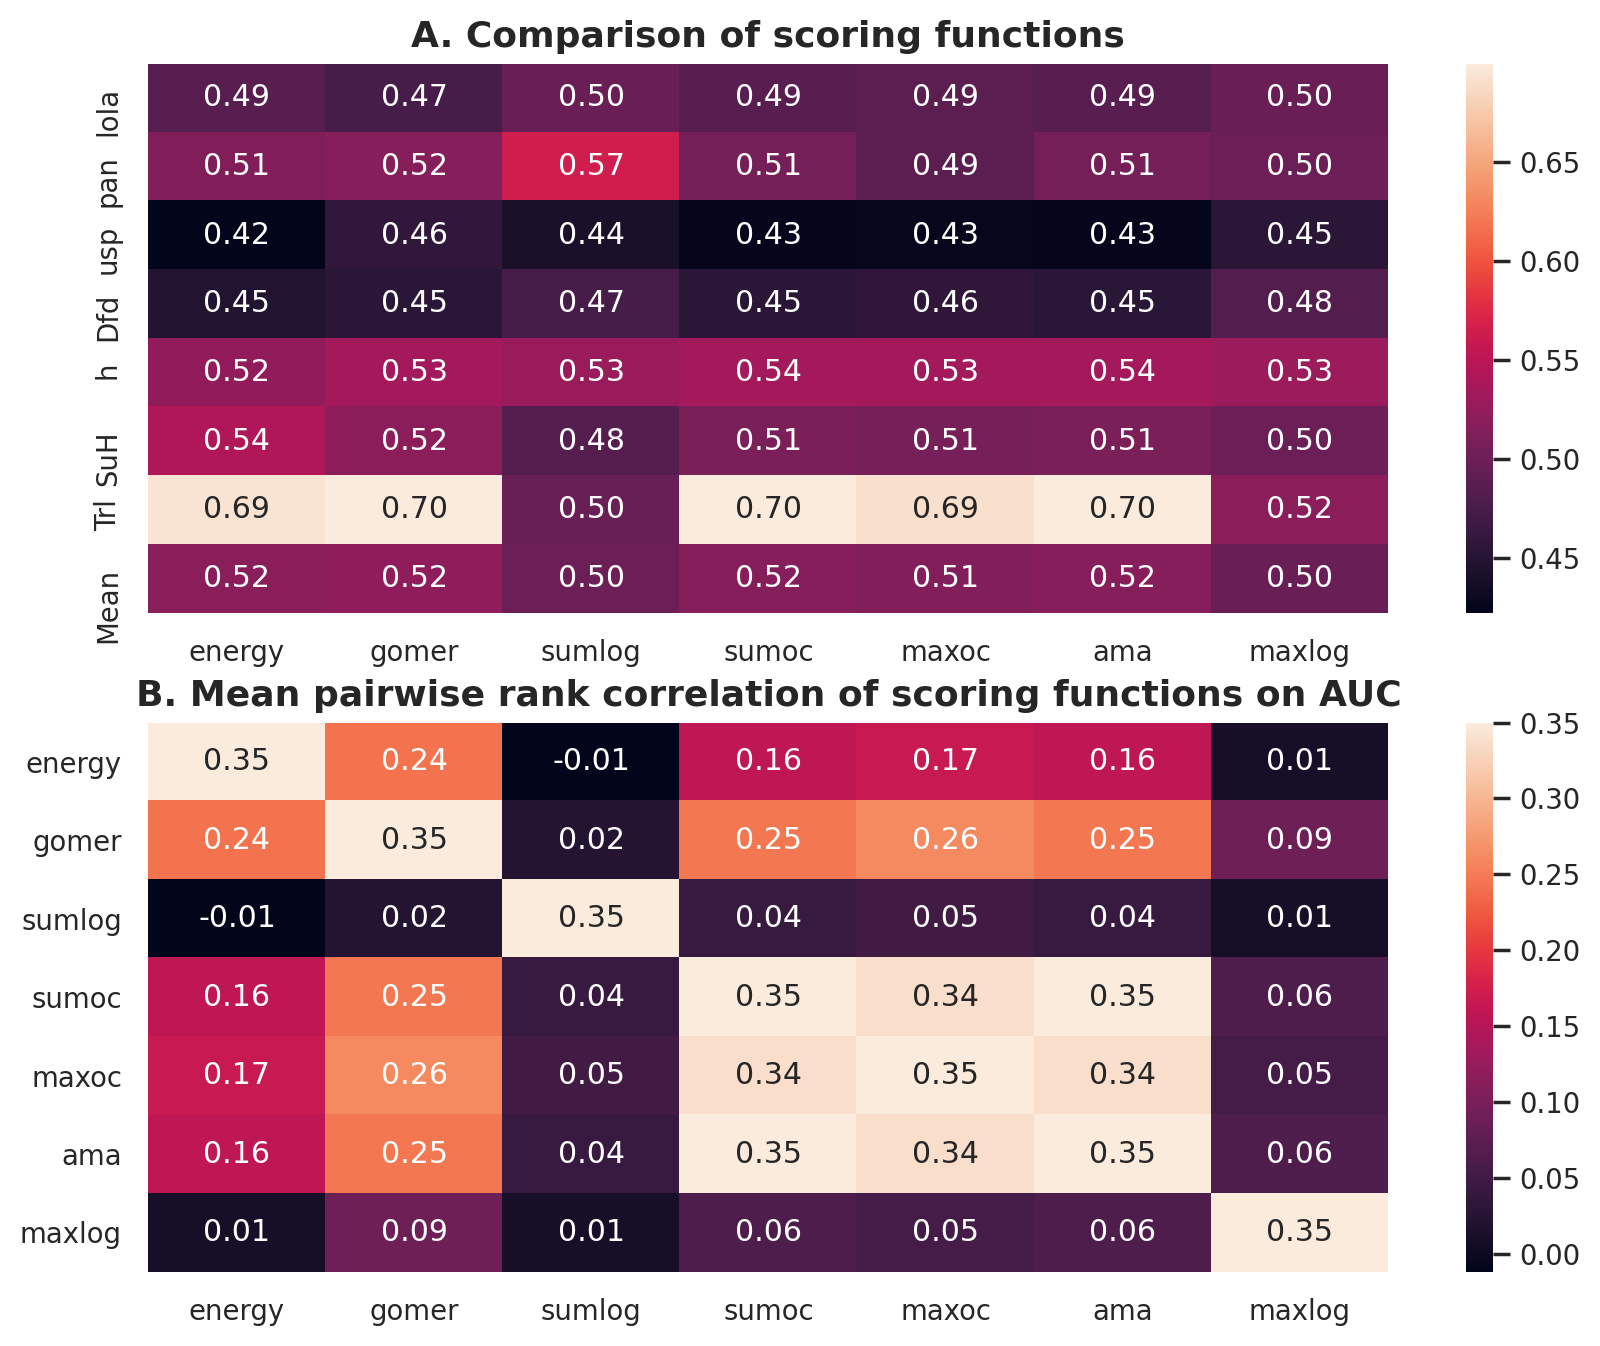

In [14]:
import seaborn as sns
stat='auc'
tf_list = ["lola", "pan", "usp", "Dfd", "h", "SuH", "Trl"]
#fig, ax = plt.subplots()
sns.set(font_scale=0.9)
fig = plt.figure(figsize=(10, 8),dpi=200)
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

scores = "energy	gomer	sumlog	sumoc	maxoc   ama	maxlog".split()

score_sum = pd.DataFrame(columns=scores)
for tf in tf_list:
    mot_score =pd.read_table("Results/%s/%s_%s.rawscores" % (tf,tf, stat), index_col="Motif")
    test = mot_score.mean().T
    con = test.to_frame(name=tf).T
    score_sum = score_sum.append(con)
score_sum = score_sum.append(score_sum.mean().to_frame(name="Mean").T)
sns.heatmap(score_sum, annot=True, ax=ax1, fmt='.2f')
ax1.set_title("A. Comparison of scoring functions",fontdict={'fontsize': 13, 'fontweight':'demibold','ma':'center'})



tf = tf_list[0]
stat = 'auc'
mot_score =pd.read_table("Results/%s/%s_%s.rawscores" % (tf,tf, stat), index_col="Motif")
a = mot_score.corr(method='spearman')

#sns.clustermap(mot_score.corr(method='spearman'))

for tf in tf_list[1:]:
    mot_score =pd.read_table("Results/%s/%s_%s.rawscores" % (tf,tf, stat), index_col="Motif")
    b = mot_score.corr(method='spearman')
    a = a.add(b)
sns.heatmap(a/20, annot=True, ax=ax2, fmt='.2f')
ax2.set_title("B. Mean pairwise rank correlation of scoring functions on AUC",
             fontdict={'fontsize': 13, 'fontweight':'semibold','ma':'center'})
f=plt.gcf()
#f.savefig('../Figures/Effect_of_scoring_auc_new.pdf', bbox_inches='tight')

# Effects of scoring MNCP

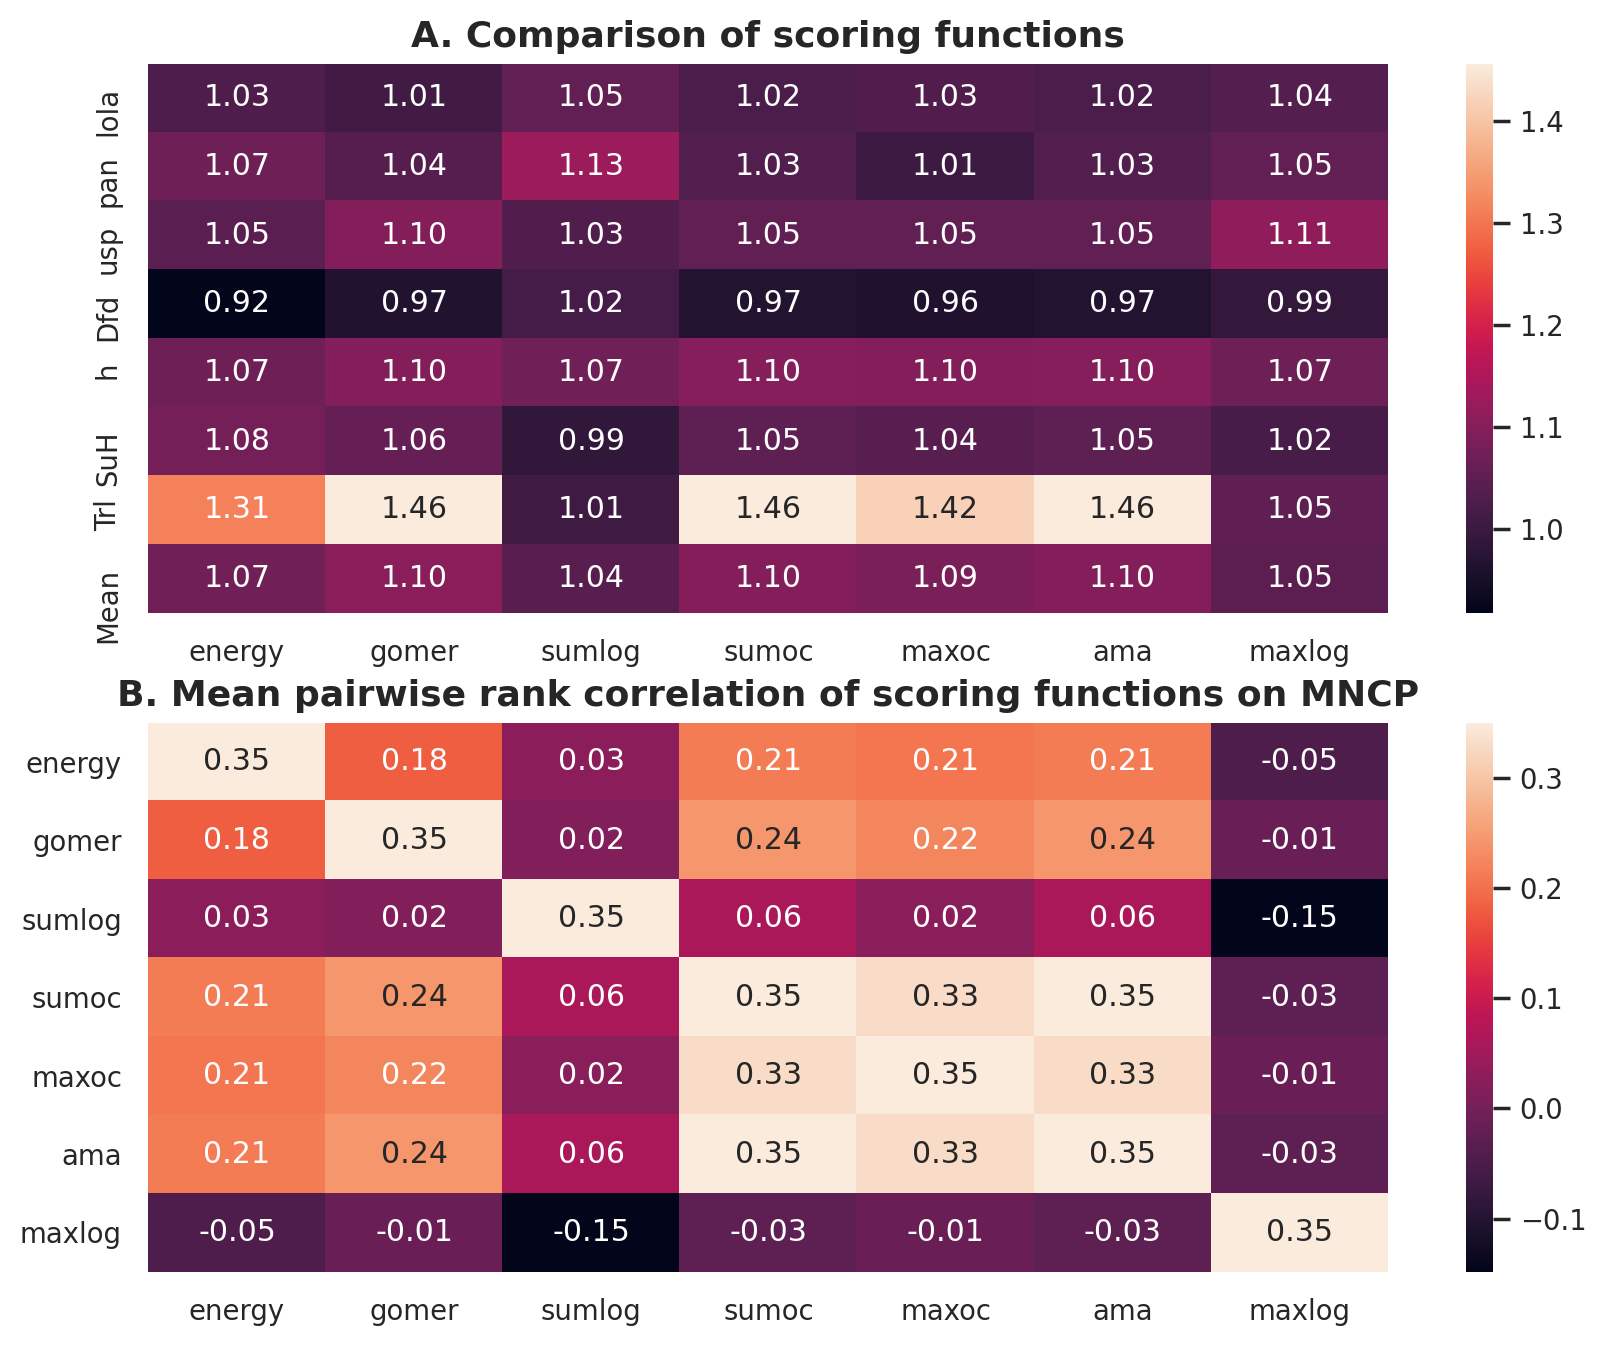

In [15]:
stat='mncp'


sns.set(font_scale=0.9)
fig = plt.figure(figsize=(10, 8),dpi=200)
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)


scores = "energy	gomer	sumlog	sumoc	maxoc  ama	maxlog".split()

score_sum = pd.DataFrame(columns=scores)
for tf in tf_list:
    mot_score =pd.read_table("Results/%s/%s_%s.rawscores" % (tf,tf, stat), index_col="Motif")
    test = mot_score.mean().T
    con = test.to_frame(name=tf).T
    score_sum = score_sum.append(con)
score_sum = score_sum.append(score_sum.mean().to_frame(name="Mean").T)
sns.heatmap(score_sum, annot=True, ax=ax1, fmt='.2f')
ax1.set_title("A. Comparison of scoring functions",fontdict={'fontsize': 13, 'fontweight':'demibold','ma':'center'})

tf = tf_list[0]
stat = 'mncp'
mot_score =pd.read_table("Results/%s/%s_%s.rawscores" % (tf,tf, stat), index_col="Motif")
a = mot_score.corr(method='spearman')

#sns.clustermap(mot_score.corr(method='spearman'))

for tf in tf_list[1:]:
    mot_score =pd.read_table("Results/%s/%s_%s.rawscores" % (tf,tf, stat), index_col="Motif")
    b = mot_score.corr(method='spearman')
    a = a.add(b)
sns.heatmap(a/20, annot=True, ax=ax2, fmt='.2f')
ax2.set_title("B. Mean pairwise rank correlation of scoring functions on MNCP",
             fontdict={'fontsize': 13, 'fontweight':'demibold','ma':'center'})

f=plt.gcf()
#f.savefig('../Figures/Effect_of_scoring_mncp_new.pdf', bbox_inches='tight')



## Corelation between gimme roc scoring function (ROC AUC and PR AUC) and Assess by score methods (AUC and MNCP)

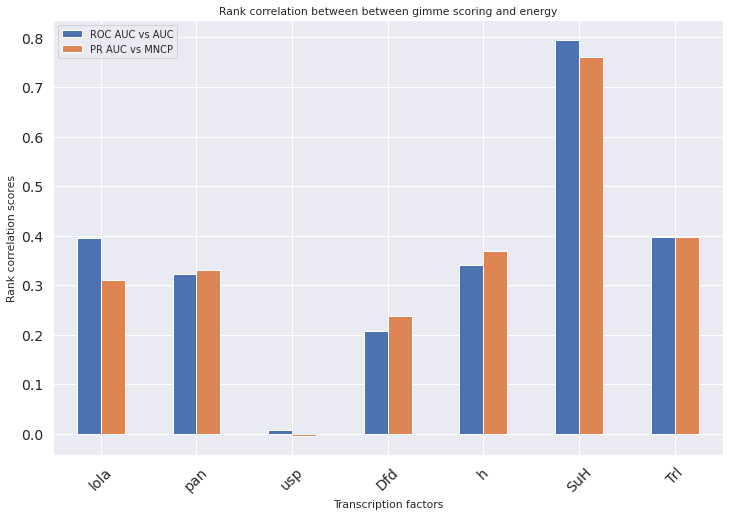

In [11]:
import pandas as pd
import numpy as np
from scipy.stats import ranksums
tf_list = ["lola", "pan", "usp", "Dfd", "h", "SuH", "Trl"]
score = "energy"

def get_corelation(tf_list, score):

    tf = tf_list[0]
    chip = pd.read_table('Results/%s/%s.gimme' 
                         % (tf, tf), index_col='Motif')
    #chip.rename(columns={'ROC AUC':'AUC'}, inplace=True)
    chip.rename(columns={'ROC AUC':'AUC','PR AUC':'MNCP' }, inplace=True)
    #chip = chip.drop(['# matches', '# matches background', 'Enr. at 1% FPR','P-value', 'PR AUC', 'log10 P-value', 'Recall at 10% FDR'], axis = 1)
    chip = chip.drop(['# matches', '# matches background', 'Enr. at 1% FPR','P-value','log10 P-value', 'Recall at 10% FDR'], axis = 1)
    dinuc = pd.read_table('Results/%s/%s.%s' % (tf, tf, score), index_col='Motif')
    #dinuc = dinuc.drop(['MNCP', 'Pearson', 'Spearman'], axis = 1) 
    dinuc = dinuc.drop([ 'Pearson', 'Spearman'], axis = 1) 

    ran_corr = ranksums(chip['AUC'], dinuc['AUC'])[1] #Determine how significantly different the scores are
    chip_rank = chip.rank(ascending=False)
    dinuc_rank = dinuc.rank(ascending=False)
    chip = chip.div(chip.max())
    dinuc = dinuc.div(dinuc.max())
    chip_mean = np.mean(chip).to_frame(name=tf)
    chip_mean_test = chip_mean.T

    a = dinuc_rank.corrwith(chip_rank, axis = 0)
    a = a.to_frame(name=tf).T
    a.head()

    for tf in tf_list[1:]:
        chip = pd.read_table('Results/%s/%s.gimme'
                             % (tf, tf), index_col='Motif')
        #chip.rename(columns={'ROC AUC':'AUC'}, inplace=True)
        chip.rename(columns={'ROC AUC':'AUC','PR AUC':'MNCP' }, inplace=True)
        #chip = chip.drop(['# matches', '# matches background', 'Enr. at 1% FPR','P-value', 'PR AUC',
                          #'log10 P-value', 'Recall at 10% FDR'], axis = 1)
        chip = chip.drop(['# matches', '# matches background', 'Enr. at 1% FPR','P-value',
                          'log10 P-value', 'Recall at 10% FDR'], axis = 1)
        dinuc = pd.read_table('Results/%s/%s.%s' % (tf, tf, score), index_col='Motif')
        #dinuc = dinuc.drop(['MNCP', 'Pearson', 'Spearman'], axis = 1) 
        dinuc = dinuc.drop([ 'Pearson', 'Spearman'], axis = 1) 

        ran_corr += ranksums(chip['AUC'], dinuc['AUC'])[1]
        chip = chip.div(chip.max())
        chip_mean = np.mean(chip).to_frame(name=tf)

        dinuc = dinuc.div(dinuc.max())

        chip_rank = chip.rank(ascending=False)
        dinuc_rank = dinuc.rank(ascending=False)
        b = dinuc_rank.corrwith(chip_rank)
        b = b.to_frame(name=tf).T
        a = a.append(b)
        chip_mean_test = chip_mean_test.append(chip_mean.T)
    #chip_mean_test.plot(kind='bar', figsize=(10,10), title="Effects of statistics on motif ranking", fontsize=14, rot=45)
    a.rename(columns={'AUC':'ROC AUC vs AUC', 'MNCP':'PR AUC vs MNCP' }, inplace=True)
    ax = a.plot(kind='bar', figsize=(12,8),
                title=(f"Rank correlation between between gimme scoring and {score}"), fontsize=14, rot=45)
    ax.set_xlabel("Transcription factors")
    ax.set_ylabel("Rank correlation scores")
    #ax.set_axis_bgcolor('W')
    fig = ax.get_figure()
    
get_corelation(tf_list, score)

energy
gomer
sumlog
sumoc
maxoc
ama
maxlog


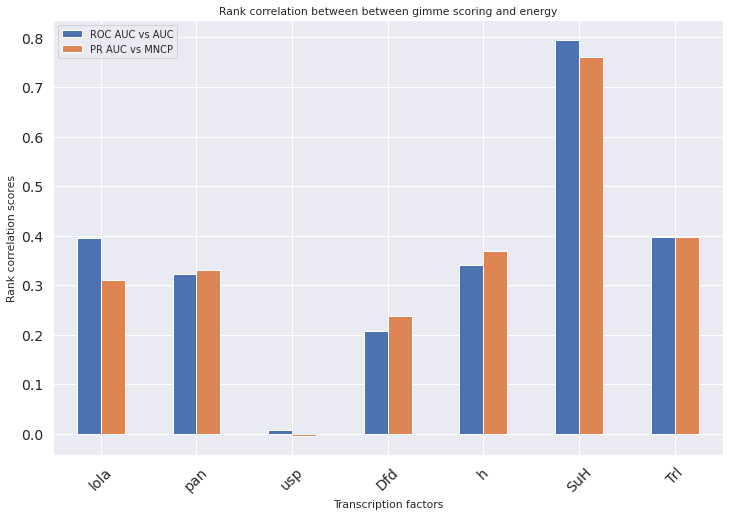

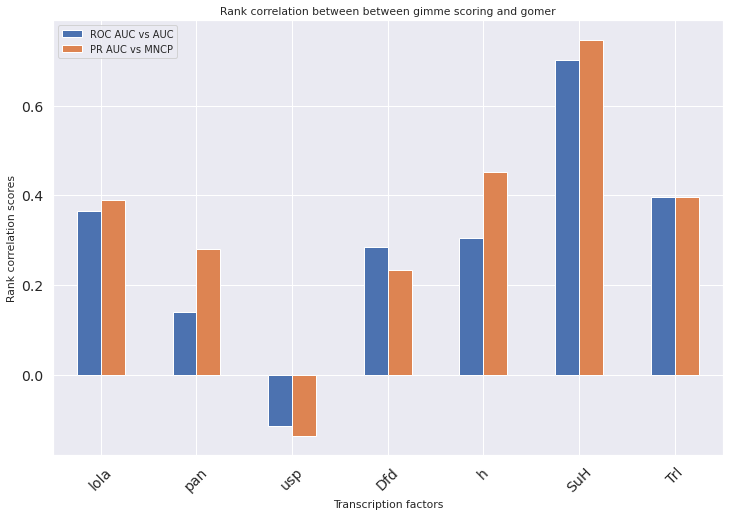

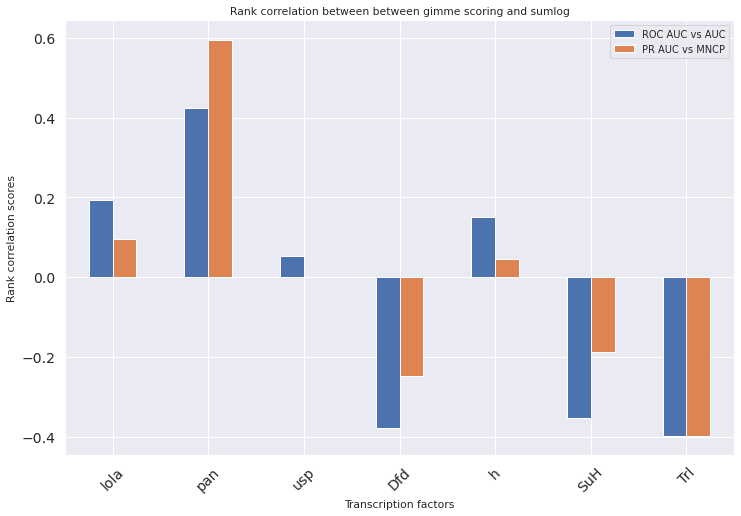

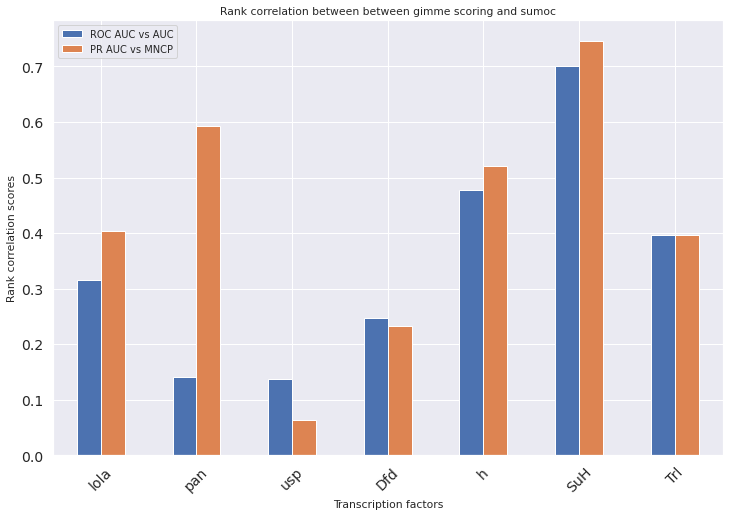

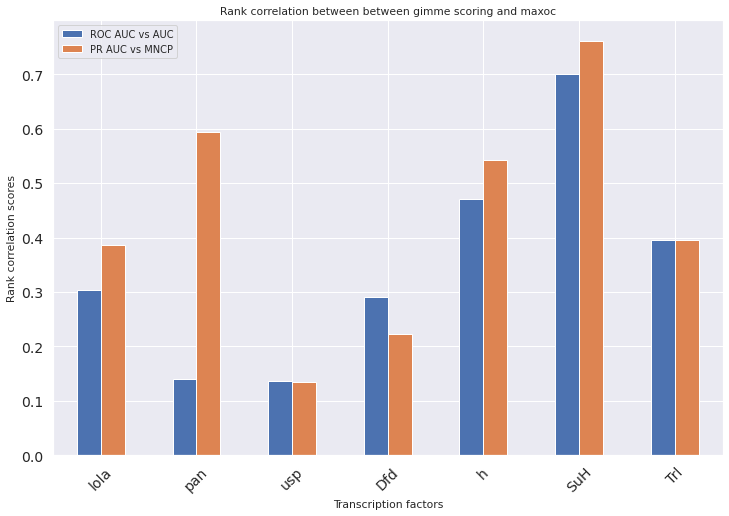

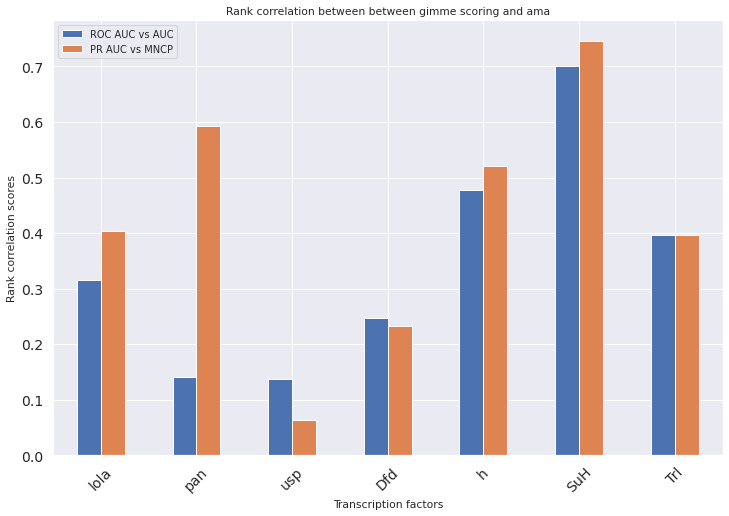

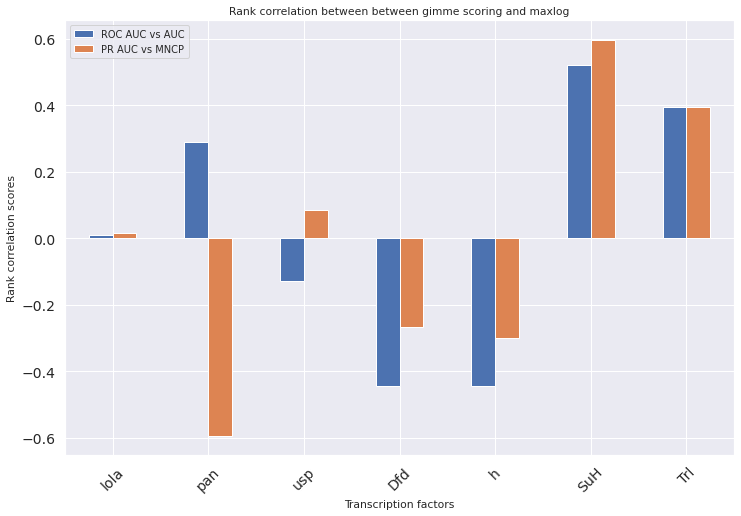

In [12]:
scores = "energy	gomer	sumlog	sumoc	maxoc  ama	maxlog".split()
for score in scores:
    print(score)
    get_corelation(tf_list, score)

# Effect of motif length, ic on scoring functions

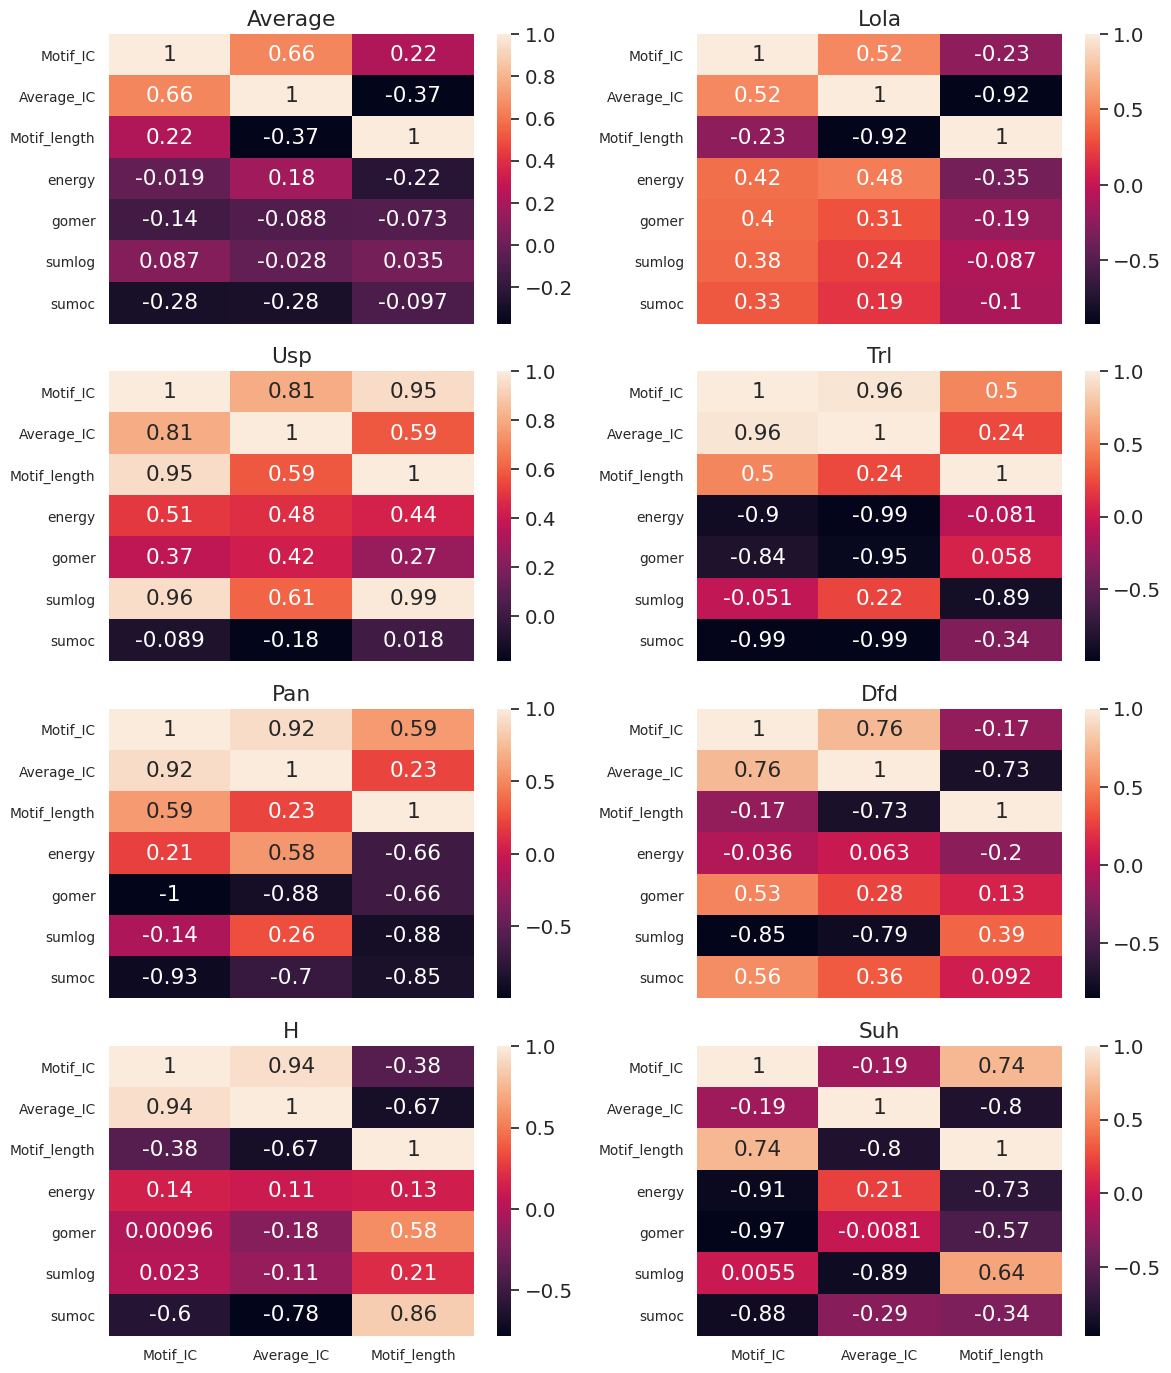

In [13]:
tf_list = ["lola", "pan", "usp", "Dfd", "h", "SuH", "Trl"]

tf = tf_list[0] #initialize
stat = 'auc'

tf_path = "Results/%s" % (tf)
df = pd.read_table("%s/%s_%s_score_ic.txt" % (tf_path, tf, stat), index_col="Motif_name")
score_ic = df.corr()

for tf in tf_list:
    tf_path = "Results/%s" % (tf)
    #df = tf+"_df"
    df1 = pd.read_table("%s/%s_%s_score_ic.txt" % (tf_path, tf,stat), index_col="Motif_name")
    score_ic2 = df1.corr()
    score_ic = score_ic.add(score_ic2, fill_value=0)
test = score_ic/(len(tf_list)+1)
test = test.drop(['energy', 'gomer', 'sumlog','sumoc'], axis = 1)

path = "Results"

f, ((ax1, ax2), (ax3, ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(4, 2, figsize=(12, 14), sharex=True, sharey=False, dpi=100)
sns.set(font_scale=1.3)
sns.heatmap(test, annot=True, ax = ax1)
ax1.set_title("Average")

def plot_effect(ax, tf):
    ax1 = ax
    path = "Results"
    tf_path = "%s/%s" % (path, tf)
    df = pd.read_table("%s/%s_%s_score_ic.txt" % (tf_path, tf, stat), index_col="Motif_name")
    df = df.corr()
    df = df.drop(['energy', 'gomer', 'sumlog','sumoc'], axis = 1)
    sns.heatmap(df, annot=True, ax = ax1)
    ax1.set_title(tf.capitalize())
    return ax1

    
ax2 = plot_effect(ax2, "lola")
ax3 = plot_effect(ax3, "usp")
ax4 = plot_effect(ax4, "Trl")
ax5 = plot_effect(ax5, "pan")
ax6 = plot_effect(ax6, "Dfd")
ax7 = plot_effect(ax7, "h")
ax8 = plot_effect(ax8, "SuH")

f.tight_layout()

#f.savefig('motif_length_ic_effect_minimal.pdf', bbox_inches='tight')